# <center> **Audio Classification using Deep Learning**


# **Introduction**


## Importing and installing the required modules


In [1]:
import importlib

def install_and_import(package):
    try:
        importlib.import_module(package)
        print(f"{package} est déjà installé.")
    except ImportError:
        print(f"{package} n'est pas installé. Installation en cours...")
        !pip install {package}
    finally:
        globals()[package] = importlib.import_module(package)
        print(f"{package} est maintenant importé.")

# Vérifier et installer les bibliothèques nécessaires
libraries_to_check = ['IPython', 'librosa', 'shutil', 'pandas', 'os', 'time', 'warnings', 'random',
                      'seaborn', 'numpy', 'tqdm', 'matplotlib', 'sklearn', 'tensorflow' , 'resampy' ]

all_libraries_found = True

for library in libraries_to_check:
    try:
        importlib.import_module(library)
        print(f"{library} est déjà installé.")
    except ImportError:
        print(f"{library} n'est pas installé. Installation en cours...")
        !pip install {library}
        all_libraries_found = False

# Afficher un message de confirmation
if all_libraries_found:
    print("Toutes les bibliothèques nécessaires sont installées et importées.")
else:
    print("Certaines bibliothèques ont été installées et importées.")


IPython est déjà installé.
librosa n'est pas installé. Installation en cours...
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/260.1 kB ? eta -:--:--
   ----------------- ---------------------- 112.6/260.1 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 260.1/260.1 kB 5.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/64.6 kB ? eta -:--:--
   ---------------------------------------- 64.6/64.6 kB ? eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   -------------------------------- ------- 0.8/1.0 MB 17.0 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 16.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/164.9 kB ? eta -:--:--
   ---------------------------------------- 164.9/164.9 kB ? eta 0:00:00
shutil est déjà installé.
pandas est déjà installé.
os est déjà installé.
time est déjà installé.
warni

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   - -------------------------------------- 0.1/3.1 MB 1.8 MB/s eta 0:00:02
   ------- -------------------------------- 0.6/3.1 MB 5.2 MB/s eta 0:00:01
   ----------------------------- ---------- 2.3/3.1 MB 14.6 MB/s eta 0:00:01
   ---------------------------------------- 3.1/3.1 MB 16.3 MB/s eta 0:00:00
Certaines bibliothèques ont été installées et importées.


In [2]:
import IPython.display as ipd
import librosa
import joblib
import librosa.display
import shutil
import pandas as pd
import os, time, warnings
import random
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)

warnings.filterwarnings("ignore")


## Creating DataFrame For models Results

In [3]:
log_cols = ["Model", "Accuracy", "Training Time", "Prediction Time"]
log = pd.DataFrame(columns=log_cols)



# **Data**


## Convert Audio File

In [4]:
def convert_ogg_to_wav(input_file, output_file):
    data, samplerate = soundfile.read(input_file)
    soundfile.write(output_file, data, samplerate, format='WAV', subtype='PCM_16')

def convert_folder_ogg_to_wav(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".ogg"):
                ogg_path = os.path.join(root, file)
                wav_path = os.path.splitext(ogg_path)[0] + ".wav"
                convert_ogg_to_wav(ogg_path, wav_path)
                print(f"Conversion: {ogg_path} -> {wav_path}")
                os.remove(ogg_path)


data_folder = 'data'

convert_folder_ogg_to_wav(data_folder)

In [5]:
import os
import shutil

# Spécifiez le chemin du dossier à nettoyer
dossier_a_nettoyer = 'data/all_data'

# Vérifiez si le dossier existe
if os.path.exists(dossier_a_nettoyer):
    # Parcourez tous les fichiers du dossier
    for fichier in os.listdir(dossier_a_nettoyer):
        chemin_fichier = os.path.join(dossier_a_nettoyer, fichier)
        try:
            if os.path.isfile(chemin_fichier):
                # Supprimez le fichier
                os.unlink(chemin_fichier)
            elif os.path.isdir(chemin_fichier):
                # Supprimez le dossier récursivement
                shutil.rmtree(chemin_fichier)
        except Exception as e:
            print(f"Erreur lors de la suppression du fichier {chemin_fichier}: {e}")

    print(f"Tous les fichiers dans {dossier_a_nettoyer} ont été supprimés.")
else:
    print(f"Le dossier {dossier_a_nettoyer} n'existe pas.")


Le dossier data/all_data n'existe pas.


## Create Audio Folder and Labels

In [6]:
def create_all_data_folder(root_folder, output_folder="all_data", csv_filename="data.csv"):
    # Créer le chemin du dossier all_data
    all_data_path = os.path.join(root_folder, output_folder)

    # Vérifier si le dossier all_data existe, sinon le créer
    if not os.path.exists(all_data_path):
        os.makedirs(all_data_path)
        print(f"Le dossier {output_folder} a été créé avec succès.")

    # Obtenir la liste des fichiers dans le dossier all_data
    existing_files = os.listdir(all_data_path)

    # Vérifier si le dossier all_data est déjà rempli
    if existing_files:
        print(f"Le dossier {output_folder} n'est pas vide. Aucune action nécessaire.")
        return

    # Parcourir les sous-dossiers (classes) dans le dossier racine
    classes = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d)) and d != output_folder]


    # Liste pour stocker les informations sur les fichiers audio
    metadata = []

    for audio_class in classes:
        class_path = os.path.join(root_folder, audio_class)

        if os.path.isdir(class_path):
            # Parcourir les fichiers audio dans chaque classe
            audio_files = [f for f in os.listdir(class_path) if f.endswith(".wav")]

            # Mélanger les fichiers audio
            random.shuffle(audio_files)

            # Copier les fichiers dans le dossier all_data
            for audio_file in audio_files:
                source_path = os.path.join(class_path, audio_file)
                dest_path = os.path.join(all_data_path, audio_file)
                shutil.copyfile(source_path, dest_path)  # Utiliser shutil.copyfile pour copier les fichiers

                # Ajouter les informations à la liste metadata
                metadata.append({"file": audio_file, "class": audio_class})

    # Créer un DataFrame avec les métadonnées
    metadata_df = pd.DataFrame(metadata)

    # Sauvegarder les métadonnées dans un fichier CSV
    csv_path = os.path.join(all_data_path, csv_filename)
    metadata_df.to_csv(csv_path, index=False)

    print(f"Le fichier CSV {csv_filename} a été créé dans le dossier {output_folder}.")


root_folder = "data"
create_all_data_folder(root_folder)


Le dossier all_data a été créé avec succès.
Le fichier CSV data.csv a été créé dans le dossier all_data.


## Reading the data


In [7]:
# reading the files
audio_dataset_path = "data/all_data/"

# loading the csv
meta_data = pd.read_csv("data/all_data/data.csv")
meta_data["class"] = meta_data["class"].replace(to_replace="Baby", value="Baby")
meta_data["class"] = meta_data["class"].replace(to_replace="Chainsaw", value="Chainsaw")
meta_data["class"] = meta_data["class"].replace(to_replace="Clocktick", value="Clock Tick")
meta_data["class"] = meta_data["class"].replace(to_replace="Cow", value="Cow")
meta_data["class"] = meta_data["class"].replace(to_replace="Dog", value="Dog")
meta_data["class"] = meta_data["class"].replace(to_replace="Fire", value="Fire")
meta_data["class"] = meta_data["class"].replace(to_replace="Frog", value="Frog")
meta_data["class"] = meta_data["class"].replace(to_replace="Helicopter", value="Helicopter")
meta_data["class"] = meta_data["class"].replace(to_replace="Pig", value="Pig")
meta_data["class"] = meta_data["class"].replace(to_replace="Rain", value="Rain")
meta_data["class"] = meta_data["class"].replace(to_replace="Rooster", value="Rooster")
meta_data["class"] = meta_data["class"].replace(to_replace="Sea", value="Sea")
meta_data["class"] = meta_data["class"].replace(to_replace="Sneeze", value="Sneeze")

meta_data["classID"] = pd.factorize(meta_data["class"])[0]


print(meta_data.head())

meta_data.head()


             file class  classID
0  2-107351-B.wav  Baby        0
1   1-22694-B.wav  Baby        0
2  1-187207-A.wav  Baby        0
3  5-198411-A.wav  Baby        0
4  5-198411-B.wav  Baby        0


file class  classID
0  2-107351-B.wav  Baby        0
1   1-22694-B.wav  Baby        0
2  1-187207-A.wav  Baby        0
3  5-198411-A.wav  Baby        0
4  5-198411-B.wav  Baby        0

In [8]:
meta_data.groupby("classID")["class"].unique()


classID
0           [Baby]
1       [Chainsaw]
2     [Clock Tick]
3            [Cow]
4            [Dog]
5           [Fire]
6           [Frog]
7     [Helicopter]
8            [Pig]
9           [Rain]
10       [Rooster]
11           [Sea]
12        [Sneeze]
Name: class, dtype: object

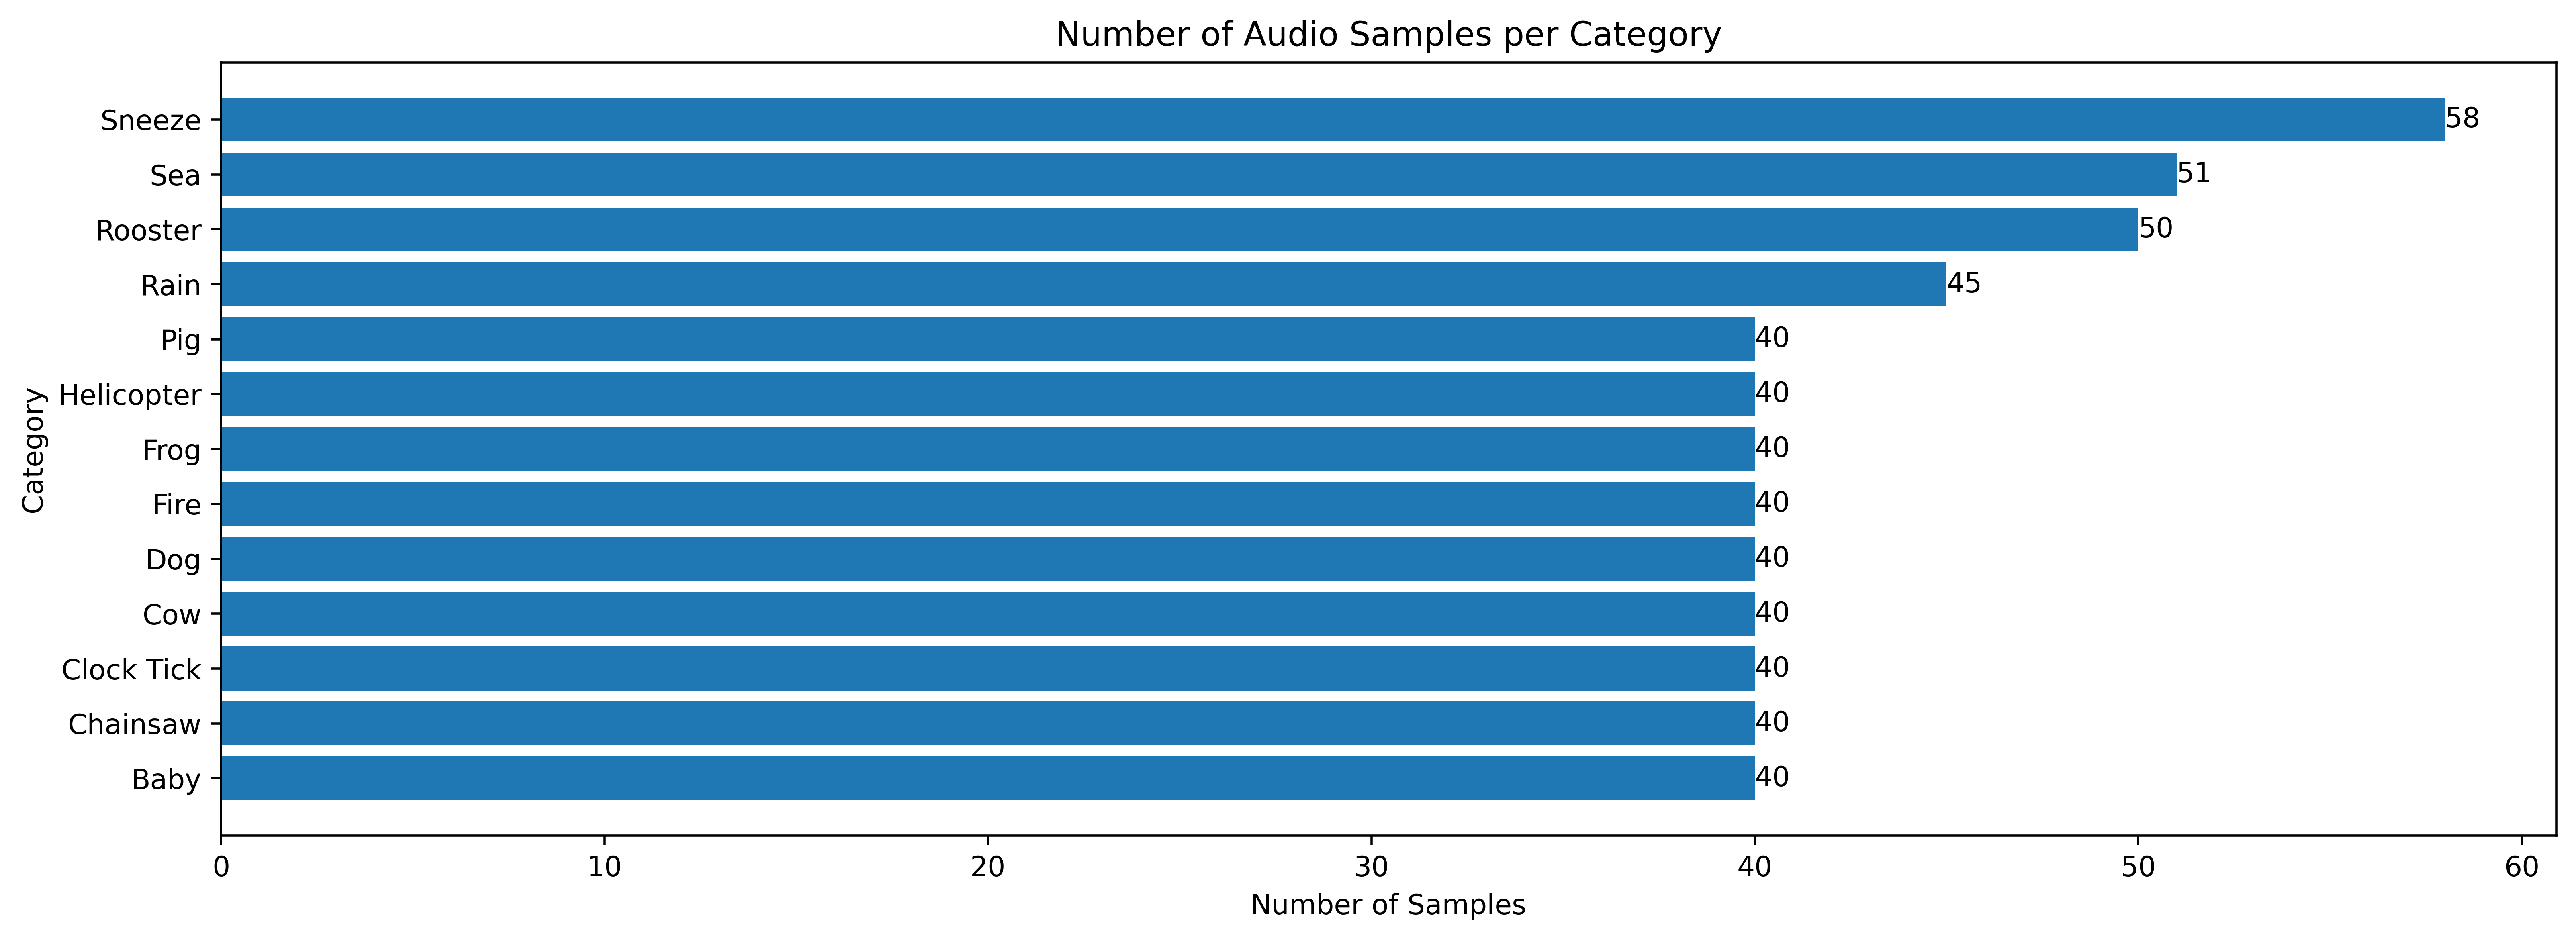

In [9]:
x = meta_data["class"].unique()
y = meta_data["class"].value_counts(ascending=True)
ind = np.arange(len(y))
# plt.figure()
fig, ax = plt.subplots(figsize=(15, 5))
ax.barh(ind, y)
ax.set_yticks(ind)
ax.set_yticklabels(x)
ax.bar_label(ax.containers[0])
plt.gcf().set_dpi(500)
plt.title("Number of Audio Samples per Category")
plt.xlabel("Number of Samples")
plt.ylabel("Category")
plt.show()


# **MFCC Visualization**


In [10]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 80






<function matplotlib.pyplot.show(close=None, block=None)>

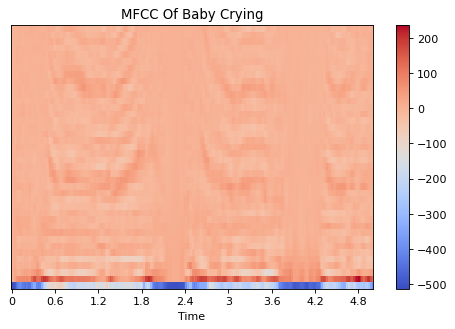

In [11]:
audio_path = audio_dataset_path + "1-187207-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Baby Crying")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

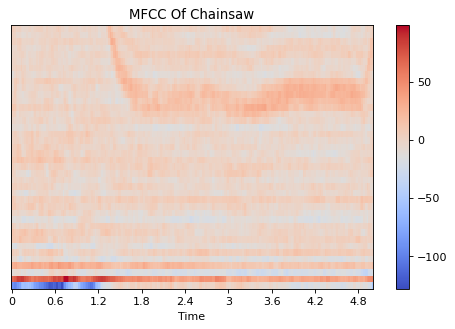

In [12]:
audio_path = audio_dataset_path + "2-50667-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Chainsaw")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

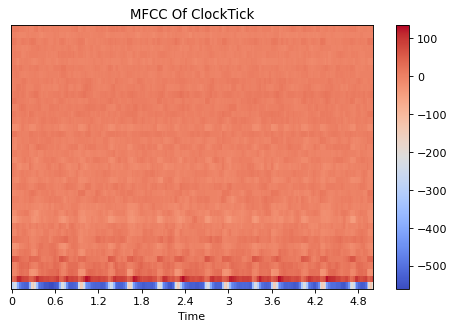

In [13]:
audio_path = audio_dataset_path + "4-198965-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of ClockTick")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

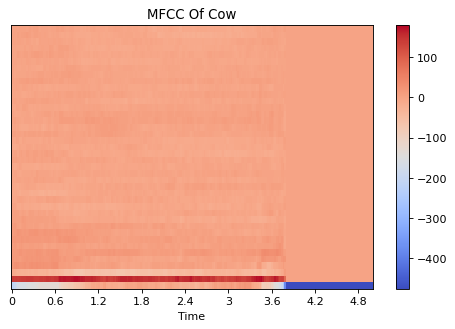

In [14]:
audio_path = audio_dataset_path + "1-77241-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Cow")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

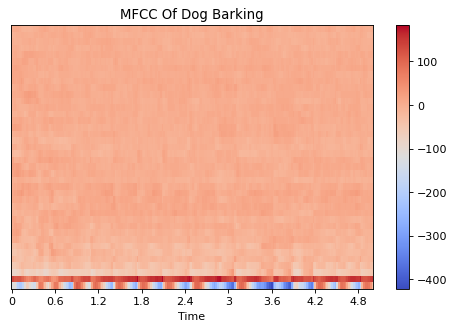

In [15]:
audio_path = audio_dataset_path + "3-144028-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Dog Barking")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

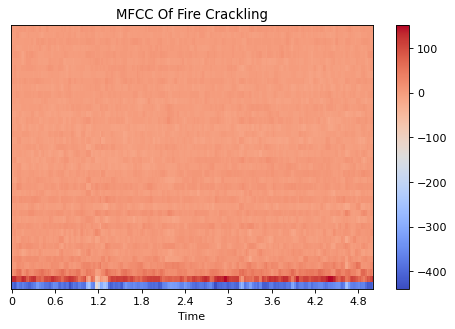

In [16]:
audio_path = audio_dataset_path + "4-182368-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Fire Crackling")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

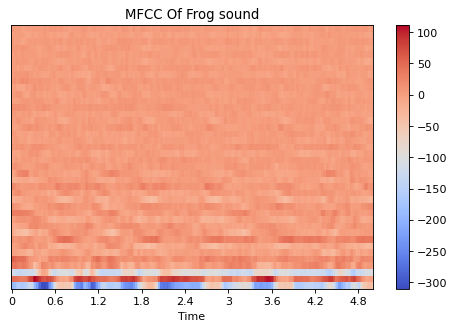

In [17]:
audio_path = audio_dataset_path + "5-189795-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Frog sound")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

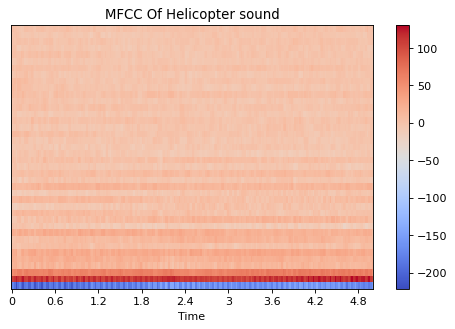

In [18]:
audio_path = audio_dataset_path + "5-177957-C.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Helicopter sound")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

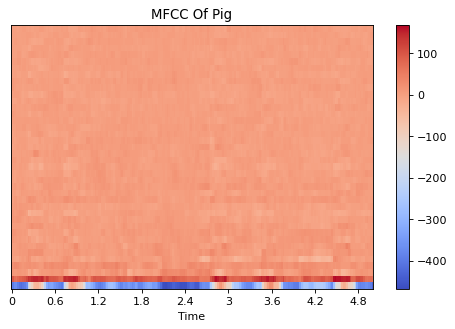

In [19]:
audio_path = audio_dataset_path + "3-257858-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Pig")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

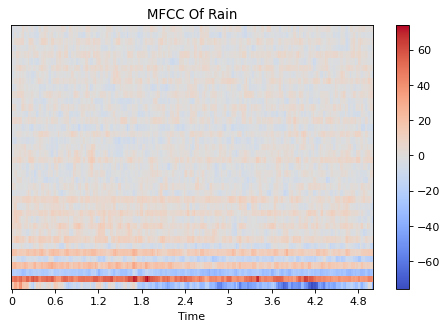

In [20]:
audio_path = audio_dataset_path + "2-117625-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Rain")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

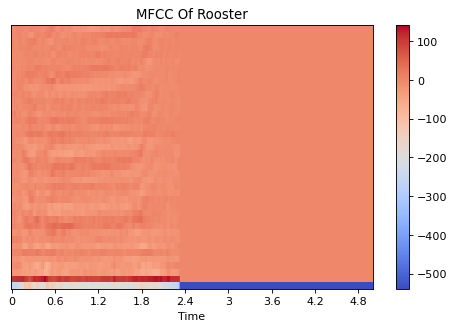

In [21]:
audio_path = audio_dataset_path + "3-137152-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Rooster")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

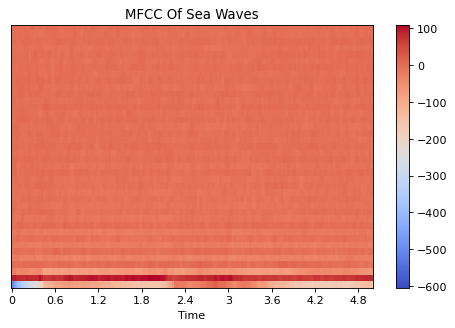

In [22]:
audio_path = audio_dataset_path + "5-219379-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Sea Waves")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

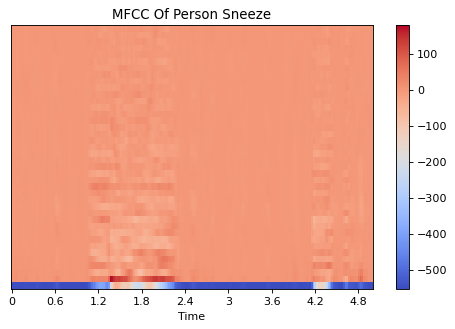

In [23]:
audio_path = audio_dataset_path + "2-93030-A.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Person Sneeze")
plt.show


# **Feature Extraction and Database Building**

## Method

1. We have used Librosa to preprocess audio file.
2. To do so, I will go through each fold and extract the data from each file using librosa's mfcc function.
3. The extracted data is appended in a list and stored in a dataframe.

### The function bellow will extract mfcc feature

In [24]:
extracted = []

for index_num, row in tqdm(meta_data.iterrows()):
    # Recuperer le fichier
    file_name = os.path.join(
        os.path.abspath(audio_dataset_path),
        row["file"]
    )
    # Recuperer La Classe
    final_class_labels = row["class"]
    # Importer les fichiers audio
    audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    # Extraction des caracterestiques
    feature = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    # Normalisation des caracterestiques
    scaled_feature = np.mean(feature.T, axis=0)
    # Stocker dans une liste
    extracted.append([scaled_feature, final_class_labels])

564it [00:23, 24.36it/s]


### Using a dataframe and pickle to save the extracted features array


In [25]:
import pandas as pd

# Convertir la liste extracted en DataFrame
columns = ["features", "class"]
extracted_df = pd.DataFrame(extracted, columns=columns)

# Enregistrer le DataFrame dans un fichier CSV
output_csv_path = "data/feature.csv"
extracted_df.to_csv(output_csv_path, index=False)
extracted_df.to_pickle("extracted_df.pkl")
extracted_df.head()
print(f"Les caractéristiques ont été enregistrées dans {output_csv_path}.")


Les caractéristiques ont été enregistrées dans data/feature.csv.


# **Data Preprocessing**


## Distribute the data to X and Y


In [26]:
final = pd.read_pickle("extracted_df.pkl")
X = np.array(final["features"].tolist())
y = np.array(final["class"].tolist())
print(X.shape)


(564, 128)


## Using LabelEncoder() to encode the string labels to an integer


In [27]:
# codage des classes
le = LabelEncoder()

# transform each category with it's respected label
Y = to_categorical(le.fit_transform(y))

# Sauvegardez l'objet LabelEncoder
joblib.dump(le, 'label_encoder.joblib')

['label_encoder.joblib']

## Split the data into train and test sets


In [28]:
# diviser les données de test et d'apprentissage
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])


Number of training samples =  451
Number of testing samples =  113


# **Model 1 - ANN**


## Building the model


In [29]:
# Construction du model

num_labels = Y.shape[1]
ANN_Model = Sequential()
ANN_Model.add(Dense(1000, activation="relu", input_shape=(128,)))
ANN_Model.add(Dense(750, activation="relu"))
ANN_Model.add(Dense(500, activation="relu"))
ANN_Model.add(Dense(250, activation="relu"))
ANN_Model.add(Dense(100, activation="relu"))
ANN_Model.add(Dense(50, activation="relu"))
ANN_Model.add(Dense(num_labels, activation="softmax"))
ANN_Model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │       129,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 750)            │       750,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       375,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,313 (5.38 MB)

 Trainable params: 1,411,313 (5.38 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the model


In [30]:
ANN_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


## Fitting the model


In [31]:
num_epochs = 250
num_batch_size = 64

t0 = time.time()
print("Shape of X_train:", X_train.shape)

ANN_Results = ANN_Model.fit(
    X_train,
    y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test),
)

ANN_Model.save("Audio_Classifier_ANN.h5")
print("ANN Model Saved")
train_hist_m1 = pd.DataFrame(ANN_Results.history)
train_m1 = round(time.time() - t0, 3)


Shape of X_train: (451, 128)
Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1017 - loss: 8.8629 - val_accuracy: 0.1062 - val_loss: 3.8935
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1796 - loss: 3.5893 - val_accuracy: 0.1504 - val_loss: 3.0517
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2331 - loss: 2.7490 - val_accuracy: 0.3186 - val_loss: 2.8809
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2356 - loss: 2.6511 - val_accuracy: 0.3982 - val_loss: 2.7529
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3517 - loss: 2.0965 - val_accuracy: 0.3540 - val_loss: 2.3046
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4145 - loss: 2.0356 - val_accuracy: 0.4779 - val_loss: 1.6511
Epoch 7/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4421 - loss: 1.4738 - val_accuracy: 0.4159 - val_loss: 1.8069
Epoch 8/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4931 - loss: 1.4448 - val_accur

ANN Model Saved


## Results


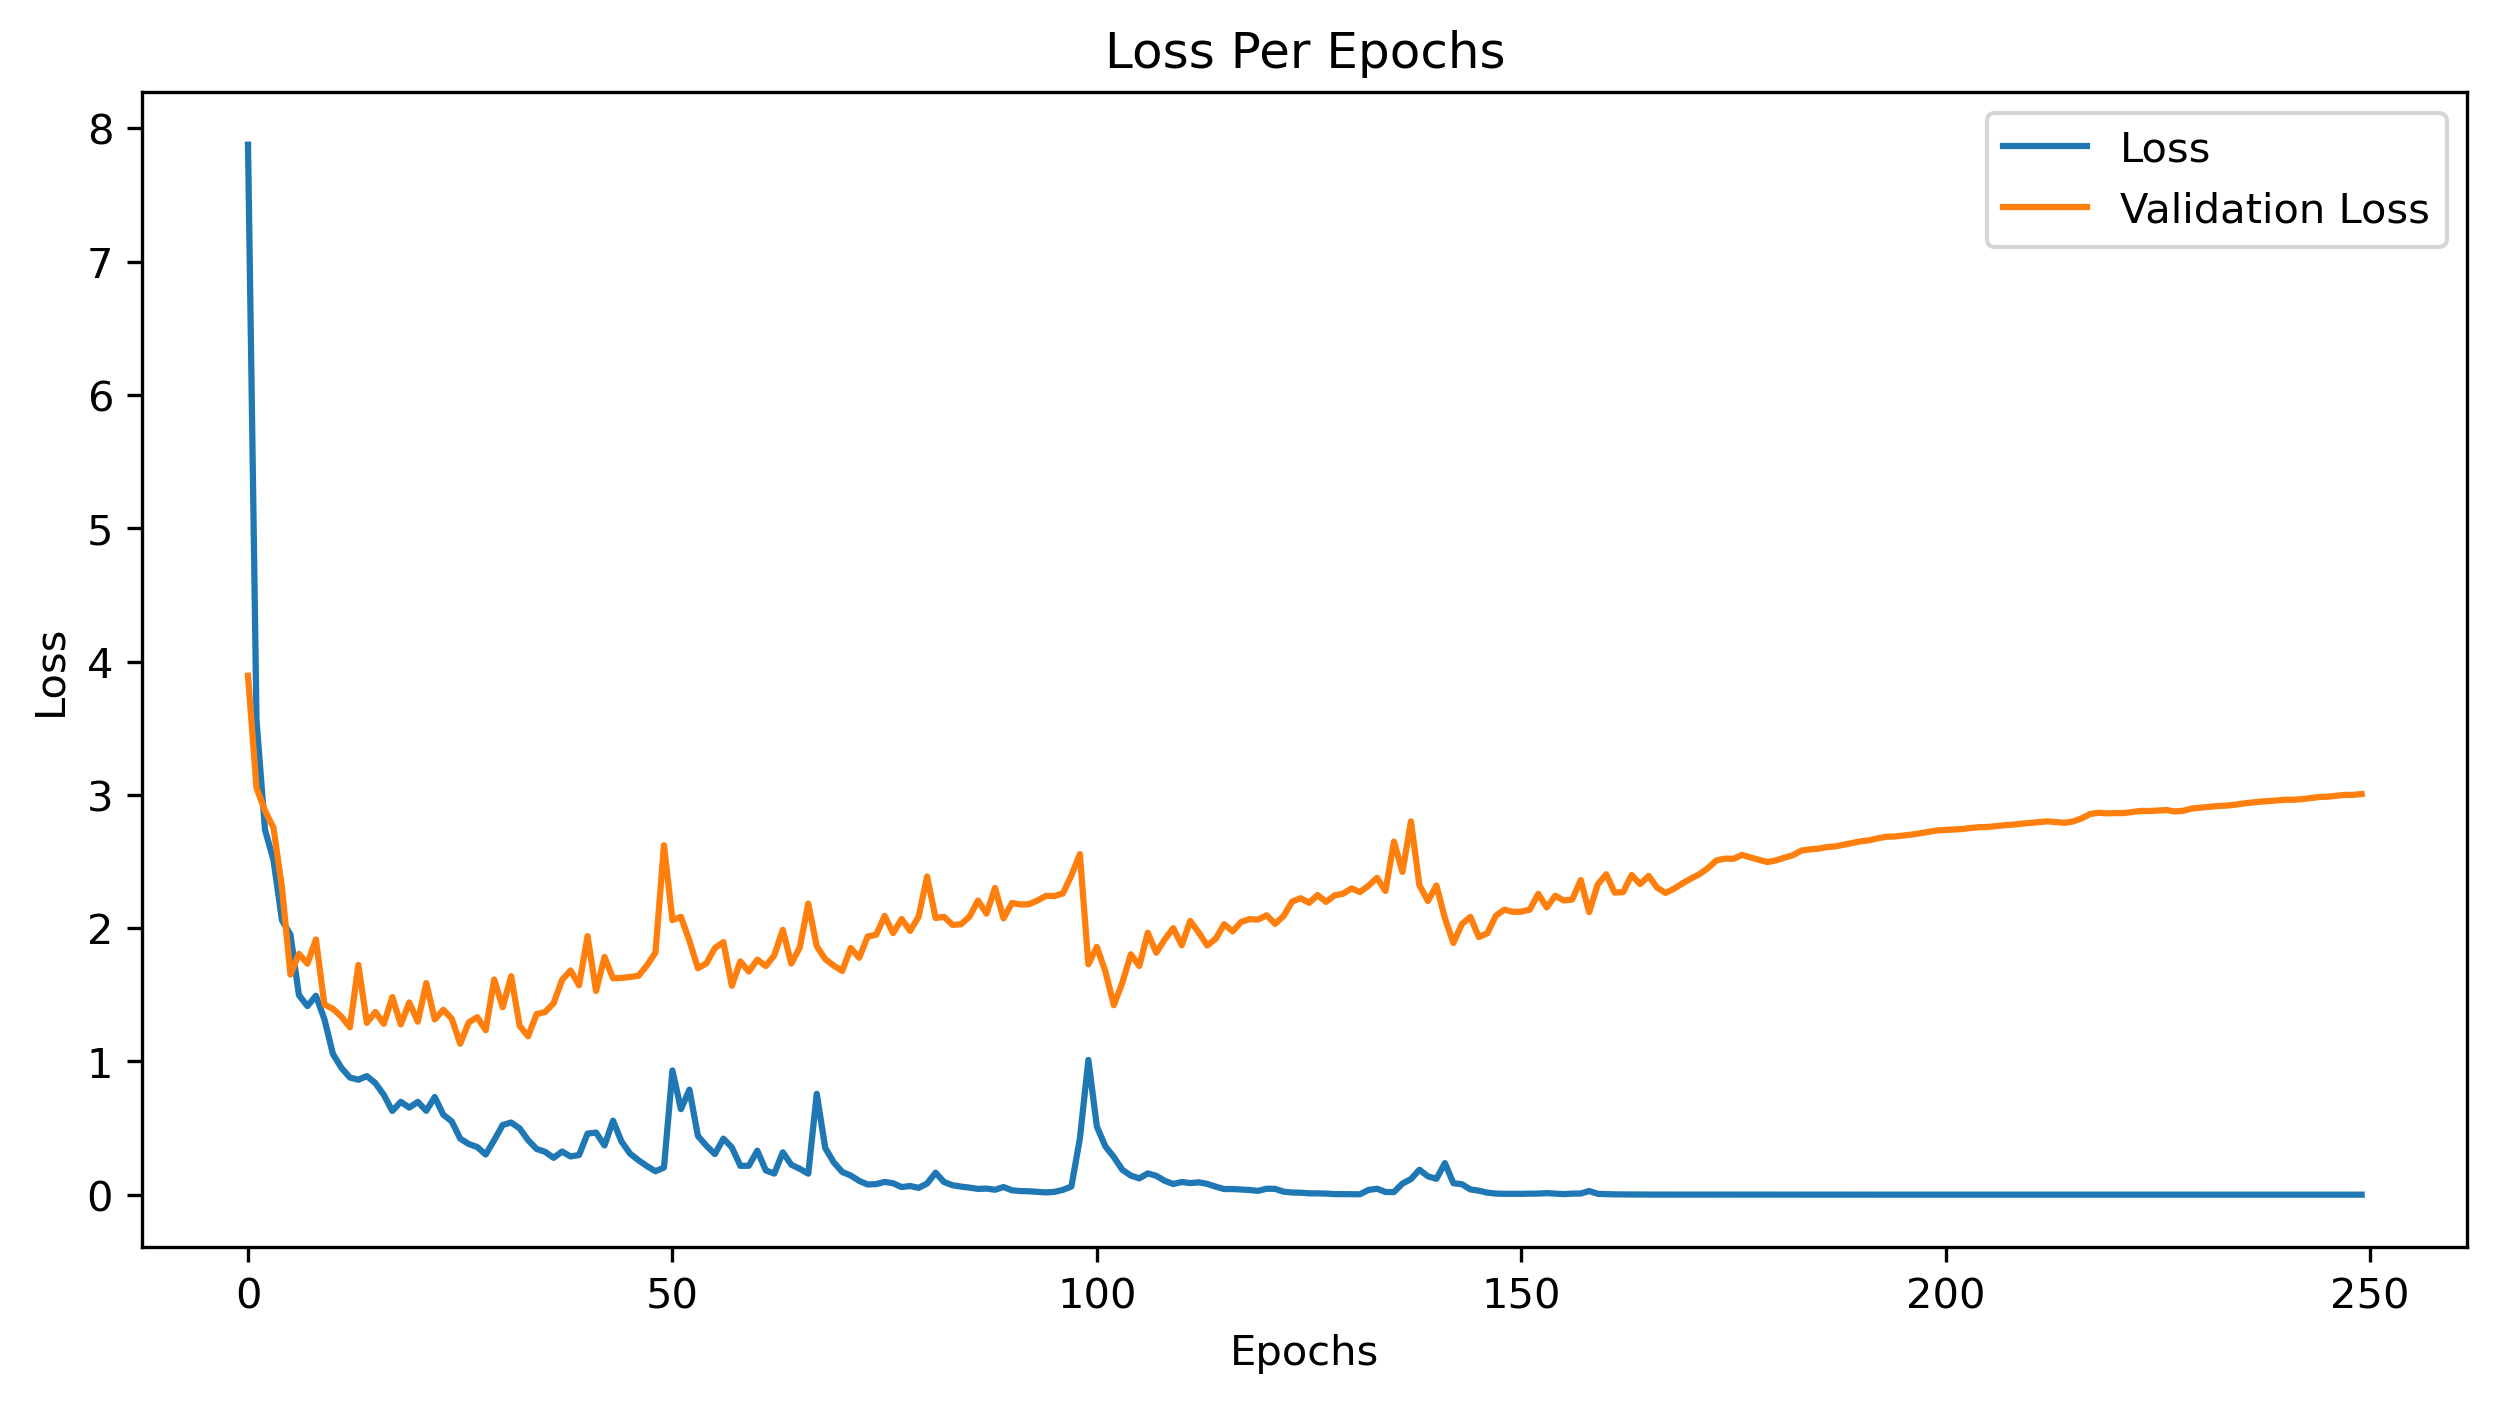

In [32]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m1[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


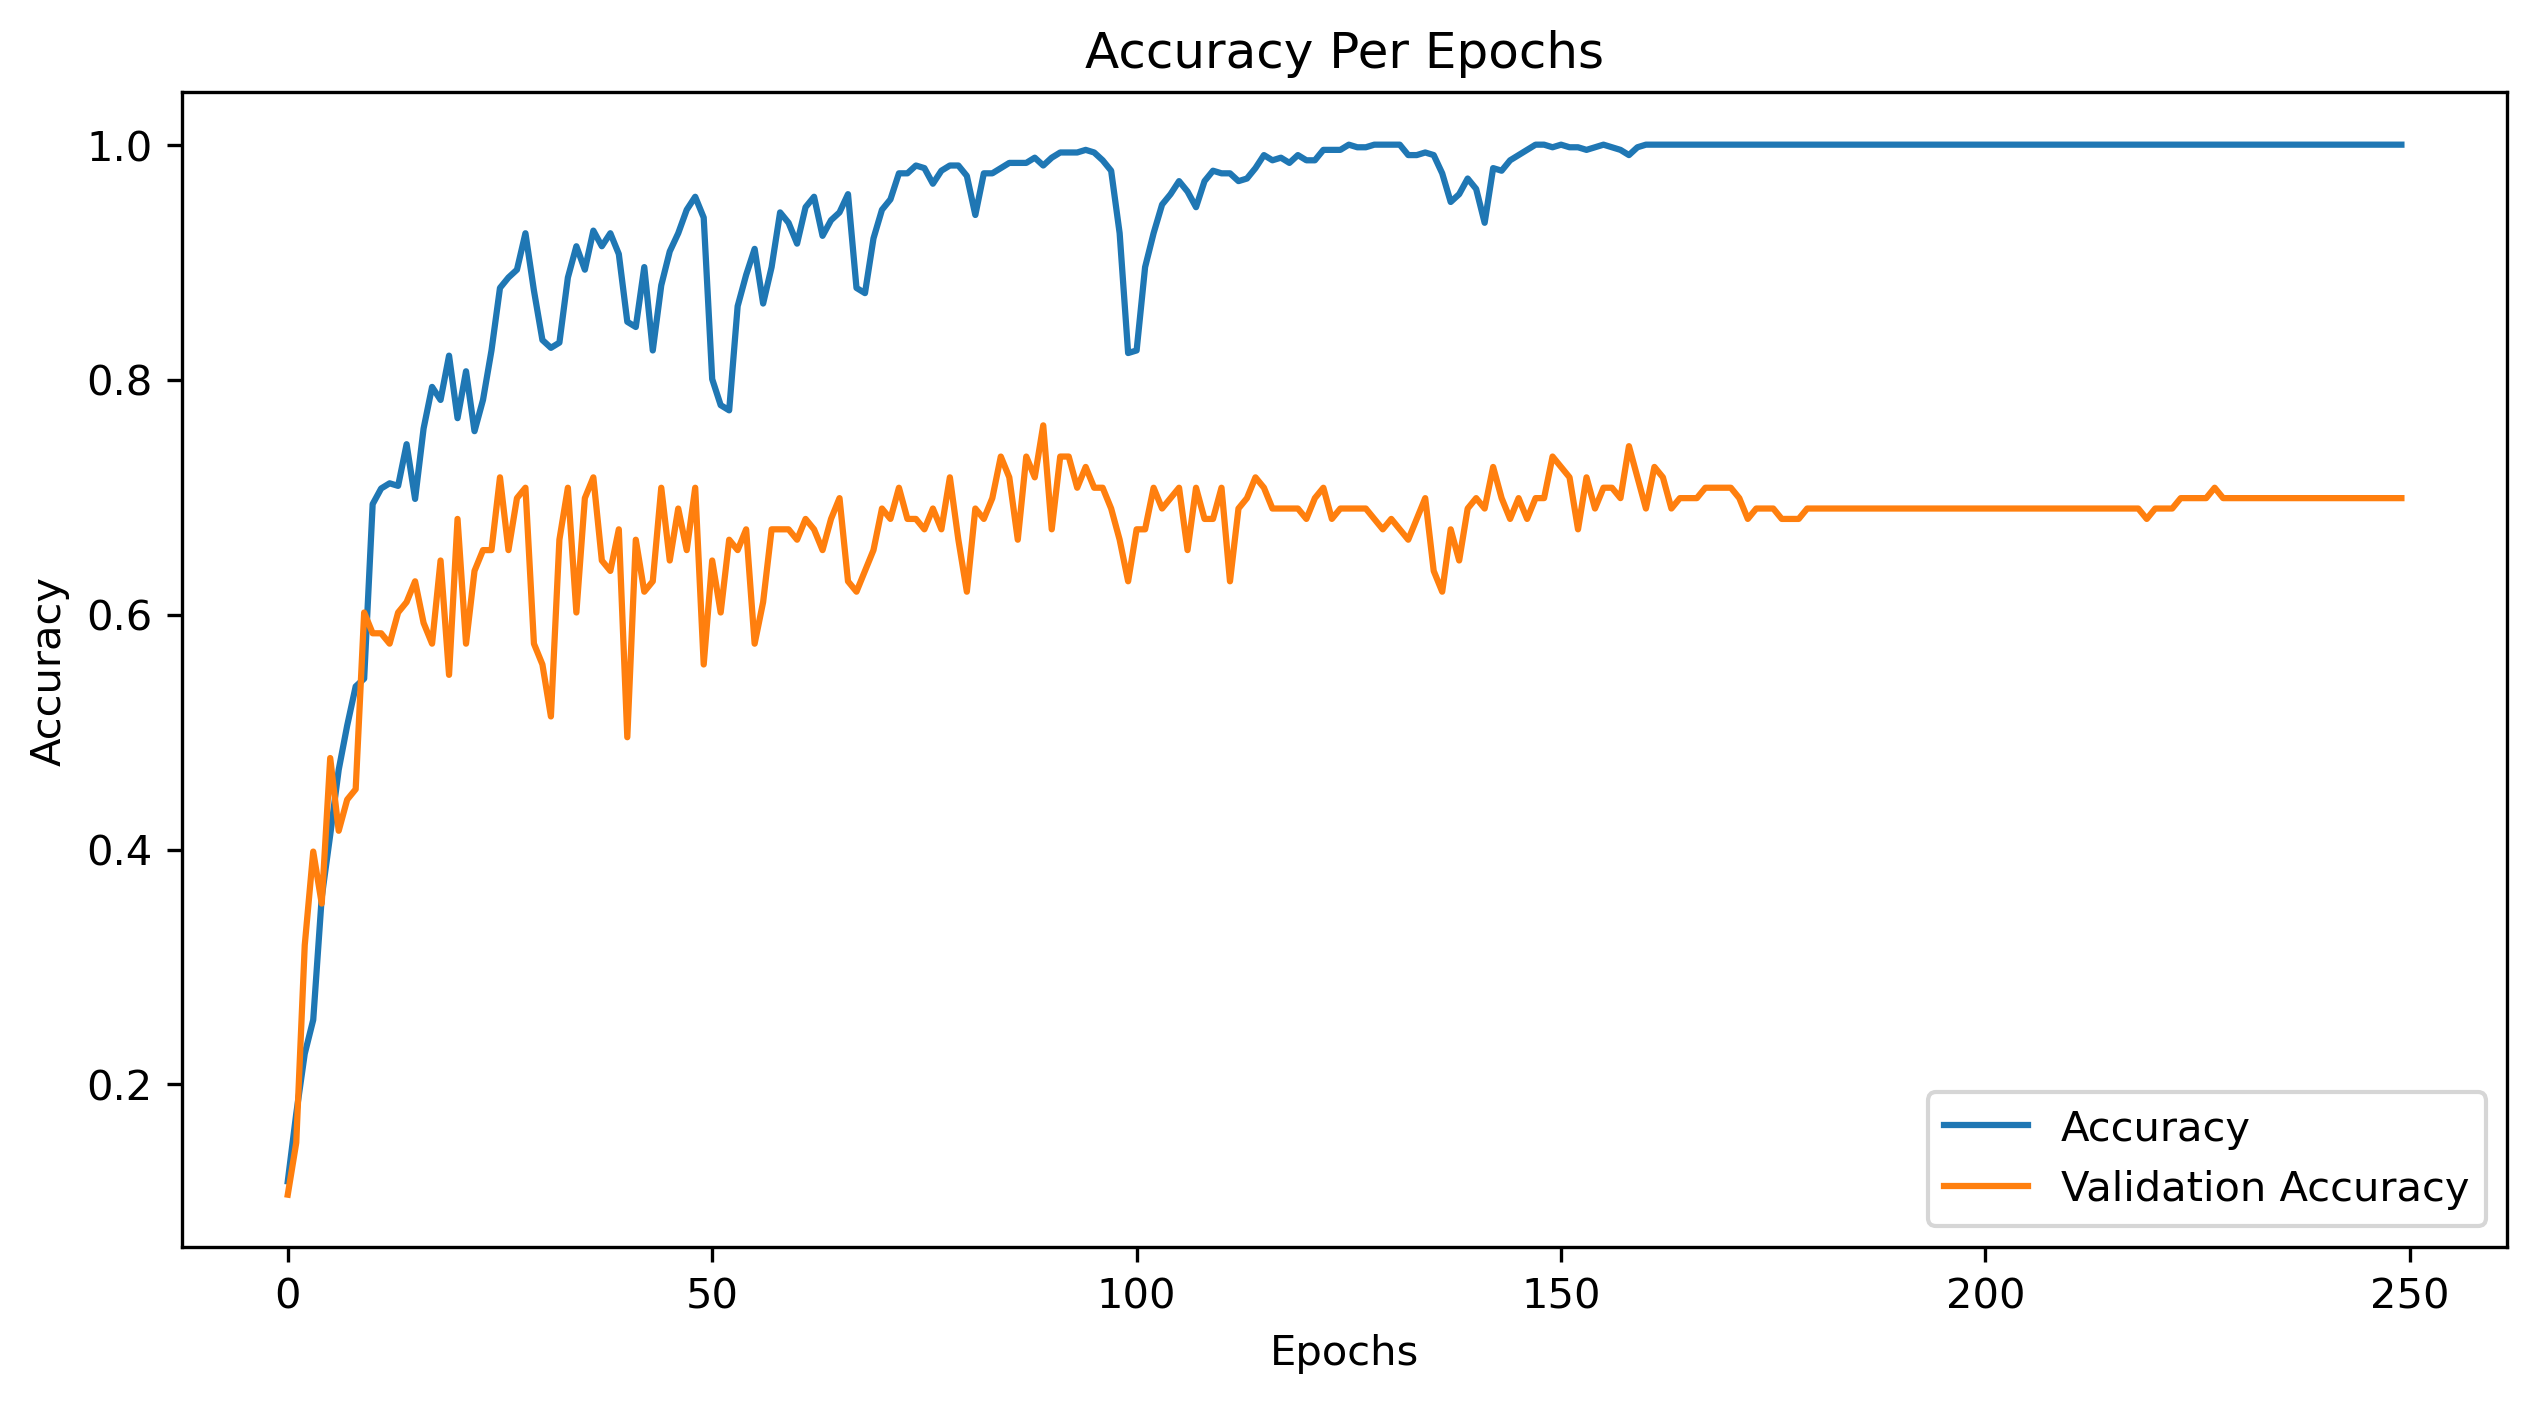

In [33]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m1[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [34]:
# Mesurer les performances et ajouter une entrée au DataFrame log
acc_m1 = ANN_Model.evaluate(X_test, y_test, verbose=0)
t0 = time.time()
y_pred_m1 = ANN_Model.predict(X_test, verbose=0)
pred_m1 = round(time.time() - t0, 3)

# Créer une nouvelle entrée à ajouter au DataFrame log
model_name = "ANN"
accuracy = acc_m1[1] * 100
training_time = train_m1
prediction_time = pred_m1

log_data = {"Model": [model_name], "Accuracy": [accuracy], "Training Time": [training_time], "Prediction Time": [prediction_time]}

# Créer le DataFrame à partir de log_data
log_cols = ["Model", "Accuracy", "Training Time", "Prediction Time"]
log_entry = pd.DataFrame(log_data, columns=log_cols)

# Ajouter l'entrée au DataFrame log
log = pd.concat([log, log_entry], ignore_index=True)

## ANN Prediction Function


In [35]:
# fonction de prediction avec le modele ANN
def ANN_Prediction(file_name):
    # load the audio file
    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    # get the feature
    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=128)
    # scale the features
    feature_scaled = np.mean(feature.T, axis=0)
    # array of features
    prediction_feature = np.array([feature_scaled])
    # get the id of label using argmax
    predicted_vector = np.argmax(ANN_Model.predict(prediction_feature), axis=-1)
    # get the class label from class id
    predicted_class = le.inverse_transform(predicted_vector)
    # display the result
    print("ANN has predicted the class as  --> ", predicted_class[0])





## Testing the Model on Sample audio


In [36]:
# Repertoire et nom du fichier
file_name = audio_dataset_path + "2-93030-A.wav"
# Fonction de prediction
ANN_Prediction(file_name)
# Jouer l'audio
ipd.Audio(file_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
ANN has predicted the class as  -->  Sneeze


# **Model 2 - CNN1D**


## Preprocessing


In [37]:
xTrainval, xTest, yTrainval, yTest = train_test_split(
    X, Y, test_size=0.1, stratify=y, random_state=387
)
xTrain, xvalid, yTrain, yvalid = train_test_split(
    xTrainval, yTrainval, test_size=0.2, stratify=yTrainval, random_state=387
)
print("\nNumber of samples for Train set :", xTrain.shape[0])
print("Number of samples for Validation set :", xvalid.shape[0])
print("Number of samples for Test set :", xTest.shape[0])

xTrain = np.expand_dims(xTrain, axis=2)
xvalid = np.expand_dims(xvalid, axis=2)

print("Shape of X Train", xTrain.shape)
print("Shape of X Test", xTest.shape)



Number of samples for Train set : 405
Number of samples for Validation set : 102
Number of samples for Test set : 57
Shape of X Train (405, 128, 1)
Shape of X Test (57, 128)


## Building the CNN1D Model


In [38]:
CNN1D_Model = Sequential()
CNN1D_Model.add(
    Conv1D(
        256,
        5,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(xTrain.shape[1], 1),
    )
)
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=13, activation="softmax"))
CNN1D_Model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 13)             │        13,325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,074,125 (4.10 MB)

 Trainable params: 1,073,613 (4.10 MB)

 Non-trainable params: 512 (2.00 KB)

## Compiling the Model


In [39]:
CNN1D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


## Fitting the Model


In [40]:
t0 = time.time()

CNN1D_Results = CNN1D_Model.fit(
    xTrain, yTrain, batch_size=64, epochs=250, validation_data=(xvalid, yvalid)
)

CNN1D_Model.save("Audio_Classifier_CNN1D.h5")
print("CNN1D Model Saved")
train_hist_m2 = pd.DataFrame(CNN1D_Results.history)
train_m2 = round(time.time() - t0, 3)


Epoch 1/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.1181 - loss: 3.1939 - val_accuracy: 0.1078 - val_loss: 2.6614
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2326 - loss: 2.4666 - val_accuracy: 0.1961 - val_loss: 2.1738
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2509 - loss: 2.0905 - val_accuracy: 0.2157 - val_loss: 2.2811
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4124 - loss: 1.8765 - val_accuracy: 0.2745 - val_loss: 2.0409
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5028 - loss: 1.4969 - val_accuracy: 0.2745 - val_loss: 1.8119
Epoch 6/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5279 - loss: 1.3562 - val_accuracy: 0.3235 - val_loss: 1.8101
Epoch 7/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5844 - loss: 1.2145 - val_accuracy: 0.3529 - val_loss: 1.8602
Epoch 8/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6081 - loss: 1.1723 - val_accuracy: 0.4804 - val_loss:

CNN1D Model Saved


## Results


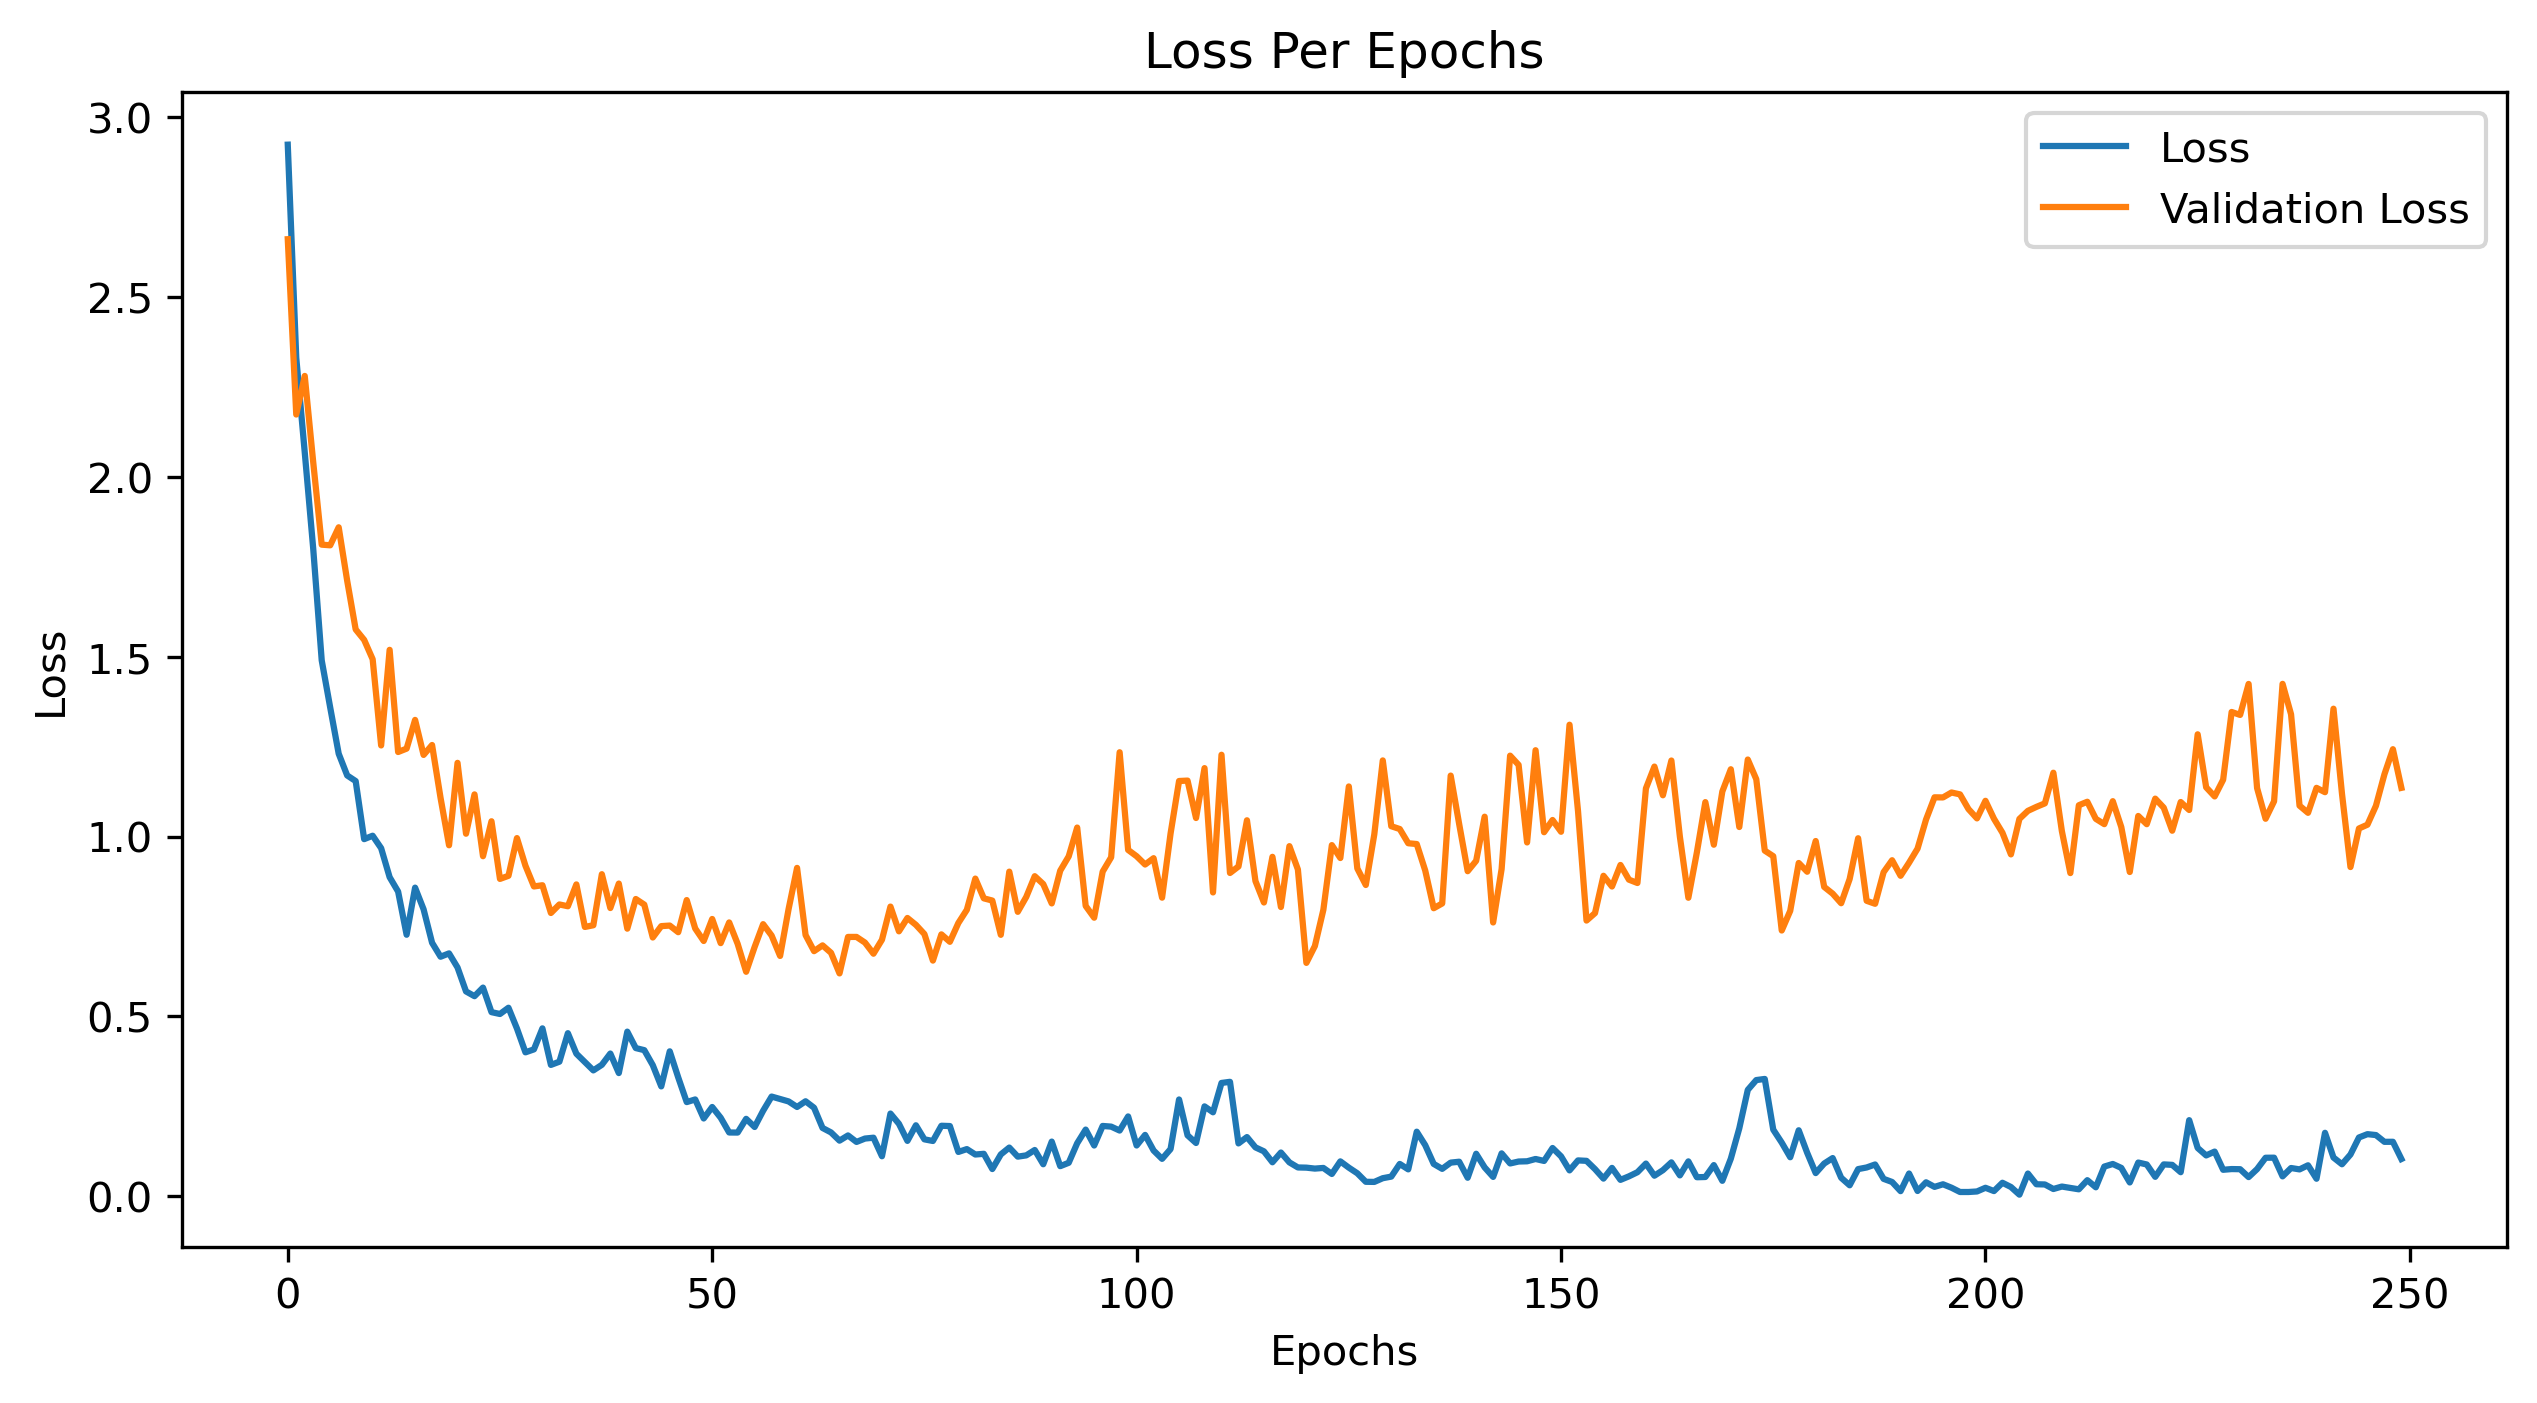

In [41]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m2[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


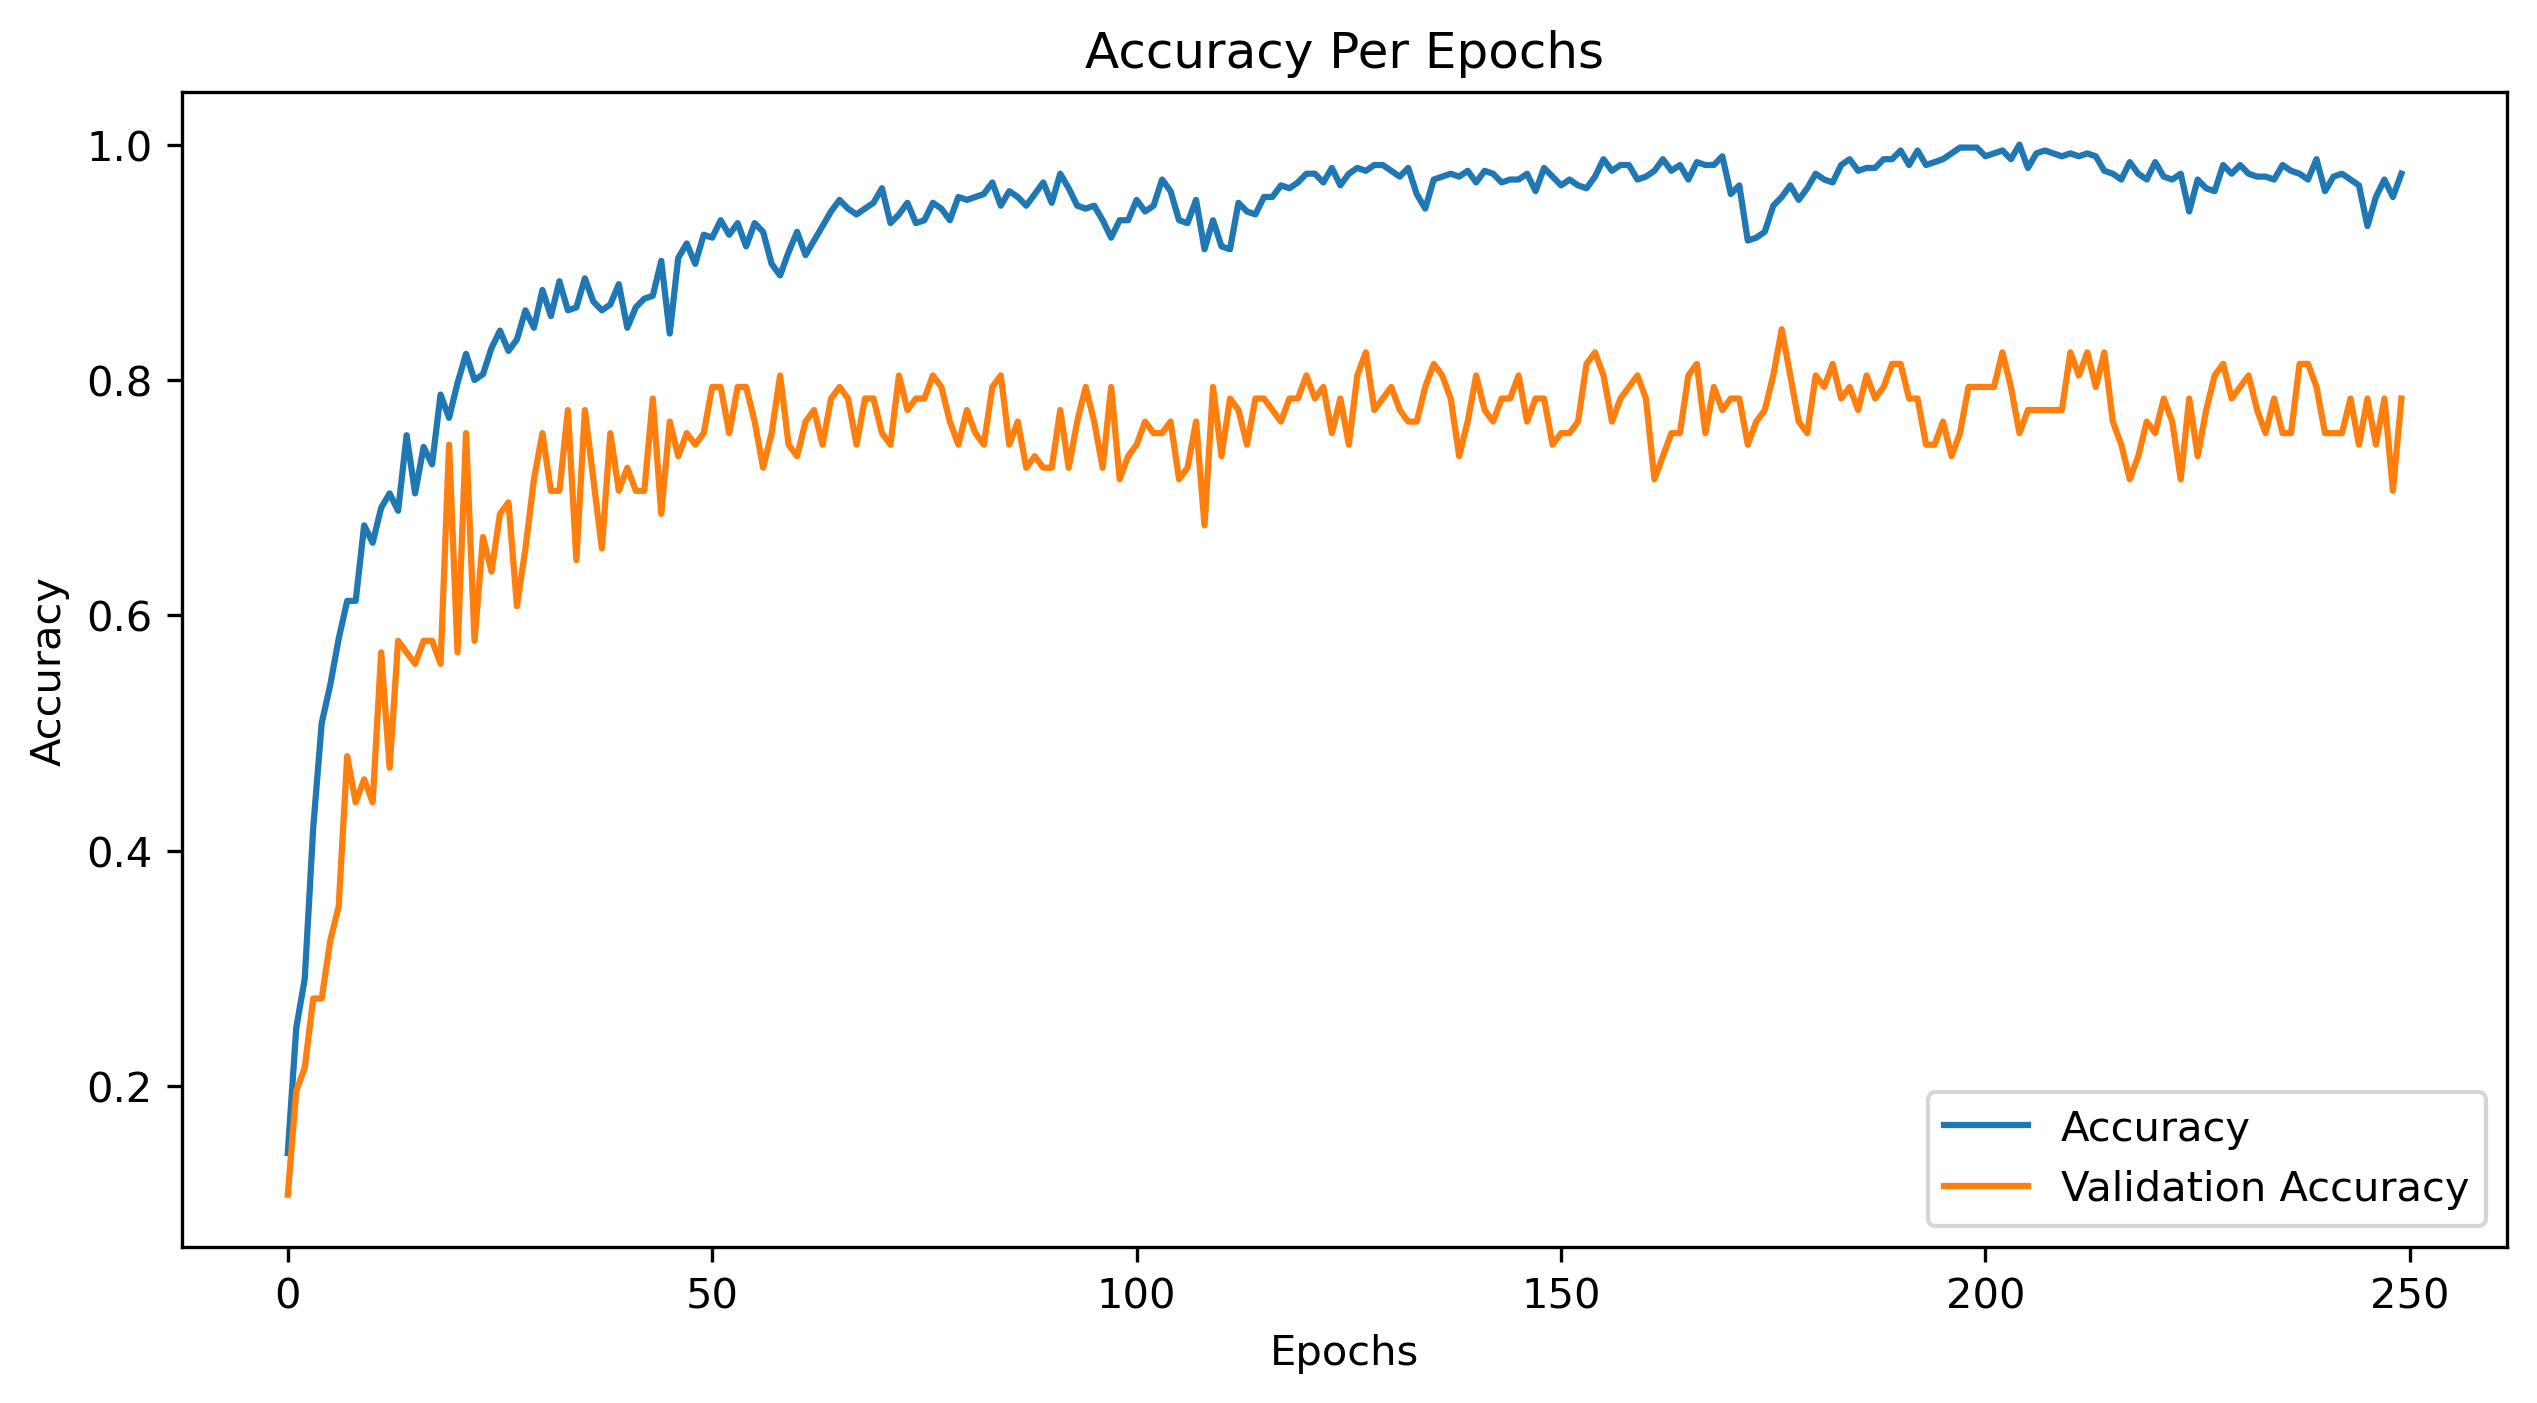

In [42]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m2[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [43]:
acc_m2 = CNN1D_Model.evaluate(xvalid, yvalid, verbose=0)
t0 = time.time()
y_pred_m2 = CNN1D_Model.predict(xvalid, verbose=0)
pred_m2 = round(time.time() - t0, 3)

# Créer une nouvelle entrée à ajouter au DataFrame log
model_name = "CNN_1D"
accuracy = acc_m2[1] * 100
training_time = train_m2
prediction_time = pred_m2

log_data = {"Model": [model_name], "Accuracy": [accuracy], "Training Time": [training_time], "Prediction Time": [prediction_time]}

# Créer le DataFrame à partir de log_data
log_cols = ["Model", "Accuracy", "Training Time", "Prediction Time"]
log_entry = pd.DataFrame(log_data, columns=log_cols)

# Ajouter l'entrée au DataFrame log
log = pd.concat([log, log_entry], ignore_index=True)

## CNN1D Prediction Function


In [44]:
# fonction de prediction CNN1D
def CNN1D_Prediction(file_name):
    # load the audio file
    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    # get the feature
    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=128)
    # scale the features
    feature_scaled = np.mean(feature.T, axis=0)
    # array of features
    prediction_feature = np.array([feature_scaled])
    # expand dims
    final_prediction_feature = np.expand_dims(prediction_feature, axis=2)
    # get the id of label using argmax
    predicted_vector = np.argmax(CNN1D_Model.predict(final_prediction_feature), axis=-1)
    # get the class label from class id
    predicted_class = le.inverse_transform(predicted_vector)
    # display the result
    print("CNN1D has predicted the class as  --> ", predicted_class[0])


## Testing the Model on Sample audio


In [45]:
# Nom fichier
file_name = audio_dataset_path + "2-93030-A.wav"
# Fonction de prediction
CNN1D_Prediction(file_name)
# Jouer le fichier audio
ipd.Audio(file_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
CNN1D has predicted the class as  -->  Sneeze


# **Model 3 - CNN2D**


## Preprocessing


In [46]:
xtrain = xTrain.reshape(xTrain.shape[0], 16, 8, 1)
xtest = xTest.reshape(xTest.shape[0], 16, 8, 1)

print("The Shape of X Train", xtrain.shape)
print("The Shape of Y Train", yTrain.shape)
print("The Shape of X Test", xtest.shape)
print("The Shape of Y Test", yTest.shape)


The Shape of X Train (405, 16, 8, 1)
The Shape of Y Train (405, 13)
The Shape of X Test (57, 16, 8, 1)
The Shape of Y Test (57, 13)


## Building the CNN2D Model


In [47]:
CNN2D_Model = Sequential()
CNN2D_Model.add(
    Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(16, 8, 1))
)
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Dropout(0.1))
CNN2D_Model.add(Flatten())
CNN2D_Model.add(Dense(1024, activation="tanh"))
CNN2D_Model.add(Dense(13, activation="softmax"))
CNN2D_Model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 8, 64)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 13)             │        13,325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,137,421 (4.34 MB)

 Trainable params: 1,137,421 (4.34 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model


In [48]:
CNN2D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


## Fitting the Model


In [49]:
t0 = time.time()

CNN2D_Results = CNN2D_Model.fit(
    xtrain, yTrain, epochs=250, batch_size=64, validation_data=(xtest, yTest)
)

CNN2D_Model.save("Audio_Classifier_CNN2D.h5")
print("CNN2D Model Saved")
train_hist_m3 = pd.DataFrame(CNN2D_Results.history)
train_m3 = round(time.time() - t0, 3)


Epoch 1/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1427 - loss: 2.8669 - val_accuracy: 0.2105 - val_loss: 2.0398
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4435 - loss: 1.7327 - val_accuracy: 0.4737 - val_loss: 1.5409
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5835 - loss: 1.2678 - val_accuracy: 0.6491 - val_loss: 1.2395
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7926 - loss: 0.8697 - val_accuracy: 0.6667 - val_loss: 1.0616
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8084 - loss: 0.6633 - val_accuracy: 0.7193 - val_loss: 0.8888
Epoch 6/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8743 - loss: 0.4651 - val_accuracy: 0.6842 - val_loss: 0.8441
Epoch 7/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9231 - loss: 0.3498 - val_accuracy: 0.7368 - val_loss: 0.8757
Epoch 8/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8916 - loss: 0.3714 - val_accuracy: 0.6140 - val_loss:

CNN2D Model Saved


## Results


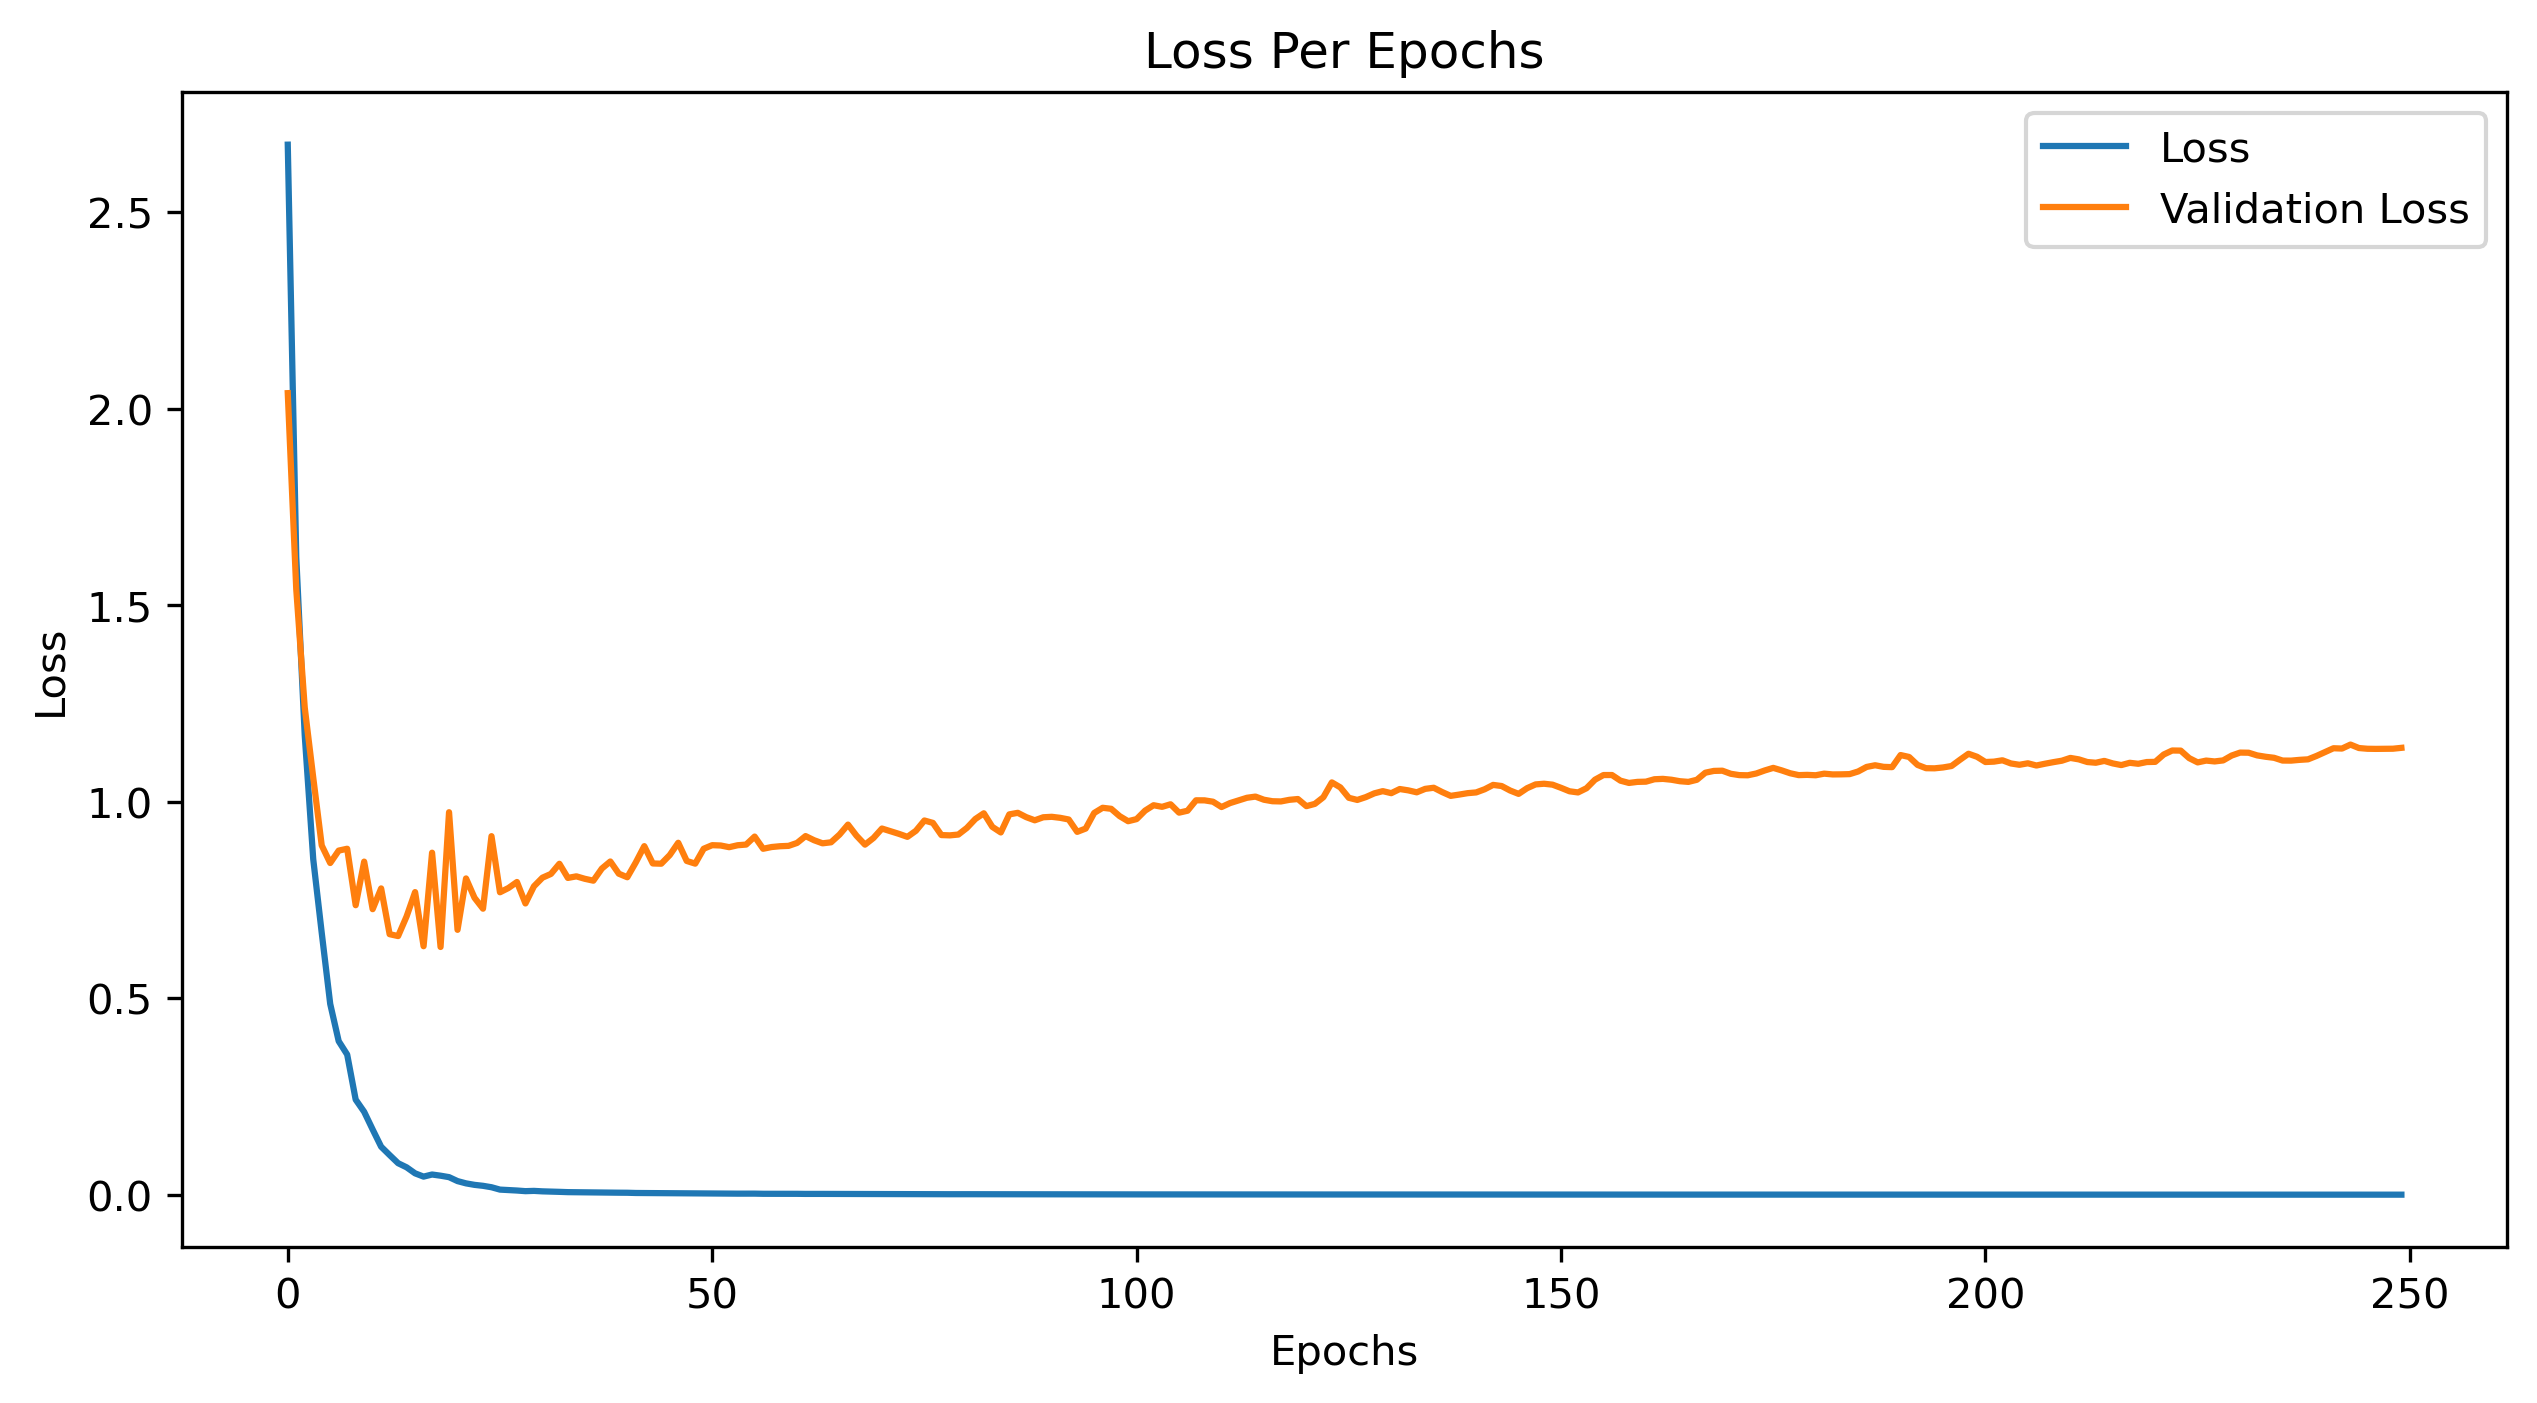

In [50]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m3[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


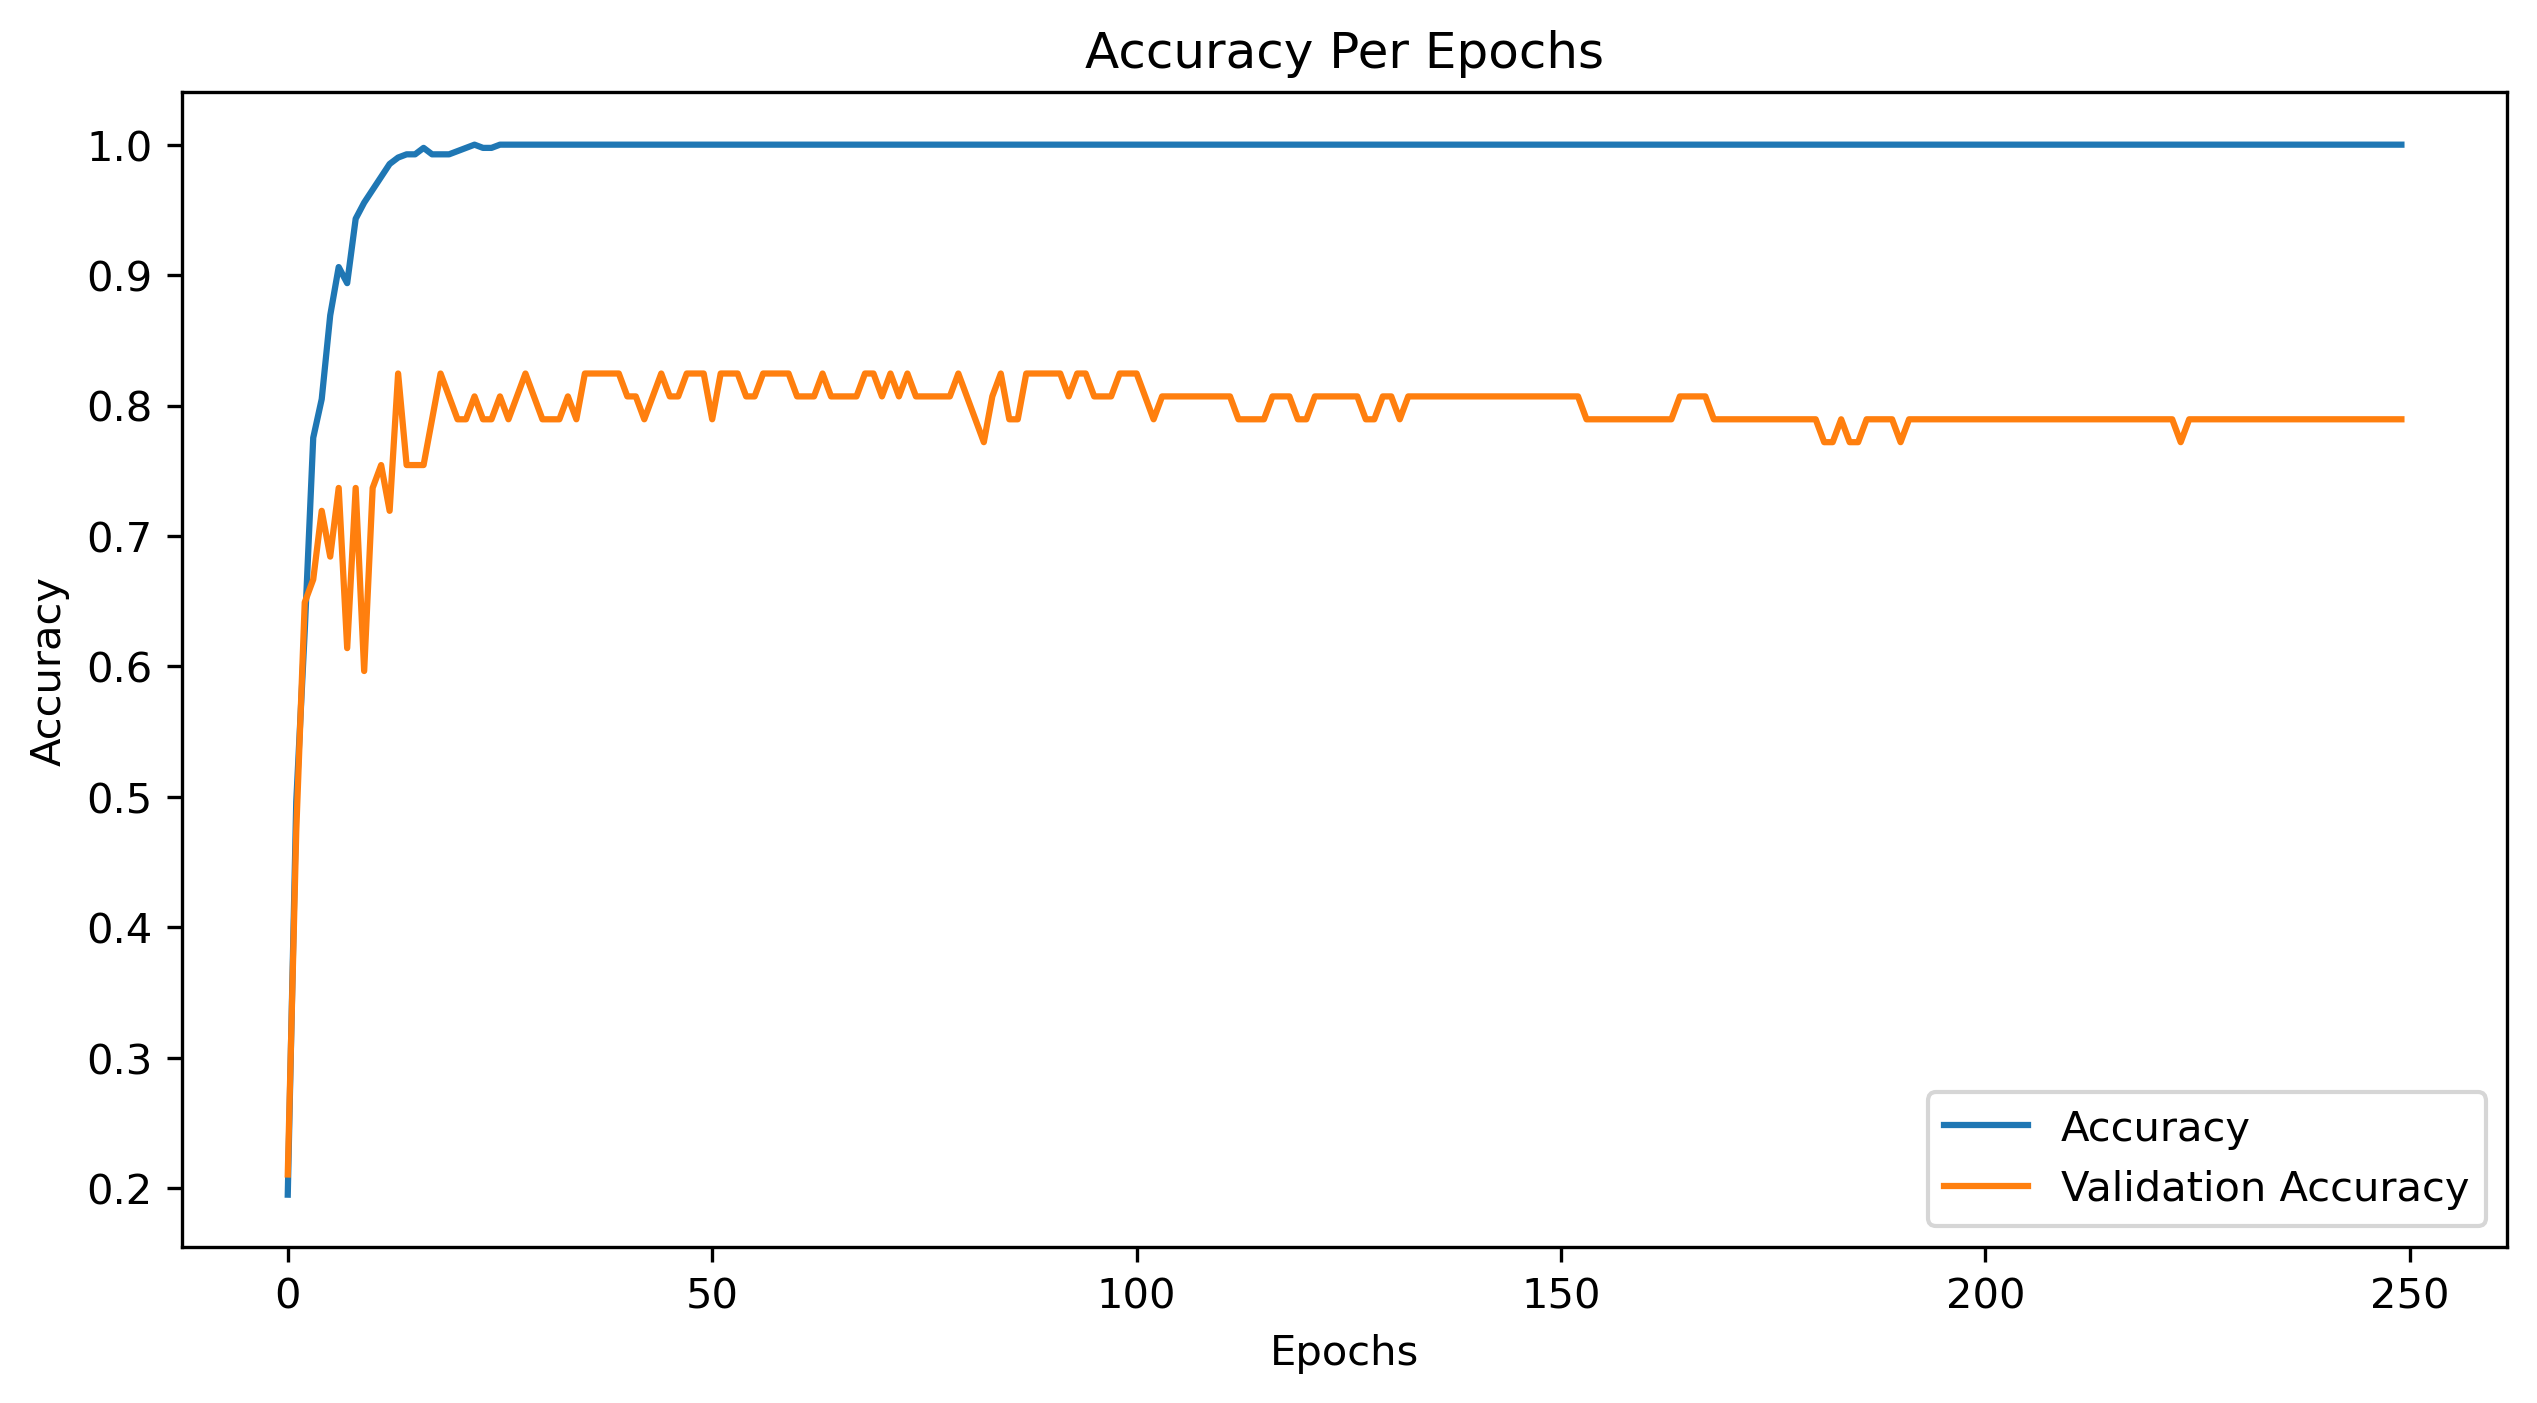

In [51]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m3[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [52]:
acc_m3 = CNN2D_Model.evaluate(xtest, yTest, verbose=0)
t0 = time.time()
y_pred_m3 = CNN2D_Model.predict(xtest, verbose=0)
pred_m3 = round(time.time() - t0, 3)
# Créer une nouvelle entrée à ajouter au DataFrame log
model_name = "CNN_2D"
accuracy = acc_m3[1] * 100
training_time = train_m3
prediction_time = pred_m3

log_data = {"Model": [model_name], "Accuracy": [accuracy], "Training Time": [training_time], "Prediction Time": [prediction_time]}

# Créer le DataFrame à partir de log_data
log_cols = ["Model", "Accuracy", "Training Time", "Prediction Time"]
log_entry = pd.DataFrame(log_data, columns=log_cols)

# Ajouter l'entrée au DataFrame log
log = pd.concat([log, log_entry], ignore_index=True)


## CNN2D Prediction Function


In [53]:
# fonction de prediction CNN2D
def CNN2D_Prediction(file_name):

    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast")

    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=128)

    feature_scaled = np.mean(feature.T, axis=0)

    prediction_feature = np.array([feature_scaled])

    final_prediction_feature = prediction_feature.reshape(
        prediction_feature.shape[0], 16, 8, 1
    )

    predicted_vector = np.argmax(CNN2D_Model.predict(final_prediction_feature), axis=-1)

    predicted_class = le.inverse_transform(predicted_vector)

    print("CNN2D has predicted the class as  --> ", predicted_class[0])


## Testing the Model on Sample audio


In [54]:
# Repertoire et nom du fichier audio
file_name = audio_dataset_path + "2-93030-A.wav"
# fonction de prediction
CNN2D_Prediction(file_name)
# jouer le fichier audio
ipd.Audio(file_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
CNN2D has predicted the class as  -->  Sneeze


# <center> **Audio Classification using Machine Learning**


## Pre Process Data


In [55]:
import os
import librosa
import pandas as pd
import numpy as np

def extract_features(file_path, feature_types):
    # import le fichier audio
    audio, sr = librosa.load(file_path, res_type='kaiser_fast')

    # Extraction des caracterestiques selon les besoins
    all_features = []

    for feature_type in feature_types:
        if feature_type == 'mfcc':
            features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=128)
        elif feature_type == 'chroma':
            features = librosa.feature.chroma_stft(y=audio, sr=sr)
        elif feature_type == 'mel':
            features = librosa.feature.melspectrogram(y=audio, sr=sr)
        elif feature_type == 'contrast':
            features = librosa.feature.spectral_contrast(y=audio, sr=sr)
        elif feature_type == 'tonnetz':
            features = librosa.feature.tonnetz(y=audio, sr=sr)


        # Normalisation avec la moyenne
        features_mean = features.mean(axis=1)
        all_features.append(features_mean)

    # Concatenate caracteristique si ya plusieurs
    if len(all_features) > 1:
        concatenated_features = np.concatenate(all_features)
        return concatenated_features
    else:
        return all_features[0]

# Charger les données à partir du fichier CSV
csv_path = "data/all_data/data.csv"
df = pd.read_csv(csv_path)

# Définir le chemin du répertoire des fichiers audio
audio_dir = "data/all_data"

# Créer une liste pour stocker les caractéristiques et les étiquettes
features = []
labels = []

# Parcourir chaque ligne du DataFrame
for index, row in df.iterrows():
    file_path = os.path.join(audio_dir, row['file'])

    # Choisissez les types de caractéristiques que vous souhaitez extraire (par exemple, ['mfcc', 'mel', 'tonnetz'])
    feature_types = ['mfcc']

    # Extraction des caracterestique selon les besoins
    extracted_features = extract_features(file_path, feature_types)

    # Ajouter les caractéristiques et l'étiquette à la liste
    features.append(extracted_features)
    labels.append(row['class'])

# Convertir les listes en DataFrame
feature_columns = [f"feature_{i}" for i in range(len(features[0]))]
features_df = pd.DataFrame(features, columns=feature_columns)
labels_df = pd.DataFrame(labels, columns=['class'])

# Concaténer les features et les labels
result_df = pd.concat([features_df, labels_df], axis=1)

# Sauvegarder le DataFrame dans un fichier CSV
result_csv_path = "data/feature_ML.csv"
result_df.to_csv(result_csv_path, index=False)

print(f"Extracted features saved to {result_csv_path}")


Extracted features saved to data/feature_ML.csv


## Distribute the data to X and Y


In [56]:
# Convertir les listes en tableaux NumPy
X = pd.DataFrame(features)
y = pd.Series(labels)
print(X)
# Encoder les étiquettes (classes)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


            0           1          2          3          4          5    \
0   -174.072144    4.475661 -81.786766  12.263878  -9.720244   1.979915   
1   -342.394135   78.553238 -13.438075   8.831688   2.651793  15.035655   
2   -284.732605  104.632553 -10.673051  10.144603 -21.894060   5.062705   
3   -278.556976   32.316105 -45.355972  16.885408  -8.242165  12.063323   
4   -263.260071   80.982491 -13.772088  31.389427 -30.389494   8.501946   
..          ...         ...        ...        ...        ...        ...   
559 -551.038025   13.101995 -11.272179   1.944736  -0.675989   0.334907   
560 -564.094666   11.808174   2.496769   4.742427   3.844247   4.623237   
561 -456.119843   33.061180  -8.579820  -0.645501  -3.359385  -2.529899   
562 -433.763947   11.600994  -6.843709   4.155115  -3.846219  -2.301940   
563 -390.846222   40.632324 -48.773510  30.698889  -0.299092  -2.574583   

           6          7         8          9    ...       118       119  \
0   -25.786463  22.24539

## Prediction Function


In [57]:
import numpy as np

def ML_prediction(file_path, model_path, feature_types):
    # Charger le modèle et l'encodeur de labels à partir des fichiers sauvegardés
    model = joblib.load(model_path)
    label_encoder = joblib.load('label_encoder.joblib')

    # Extraire les caractéristiques du fichier audio
    extracted_features = extract_features(file_path, feature_types)

    # Convertir les caractéristiques en tableau NumPy
    features_array = np.array([extracted_features])

    # Assurer que le tableau est C-contiguous
    features_array = np.ascontiguousarray(features_array)

    # Effectuer la prédiction
    prediction = model.predict(features_array)

    # Convertir la prédiction en classe réelle
    predicted_class = label_encoder.inverse_transform(prediction)[0]
    print("Predicted class: ", predicted_class)


# **Model 4 - Gaussian NB**


## Fitting the model


In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report , accuracy_score

# Créer le classificateur Naive Bayes gaussien
model_GaussNB = GaussianNB()

# Mesurer le temps d'entraînement
start_time = time.time()
model_GaussNB.fit(X_train, y_train)
train_m4 = time.time() - start_time


## Results


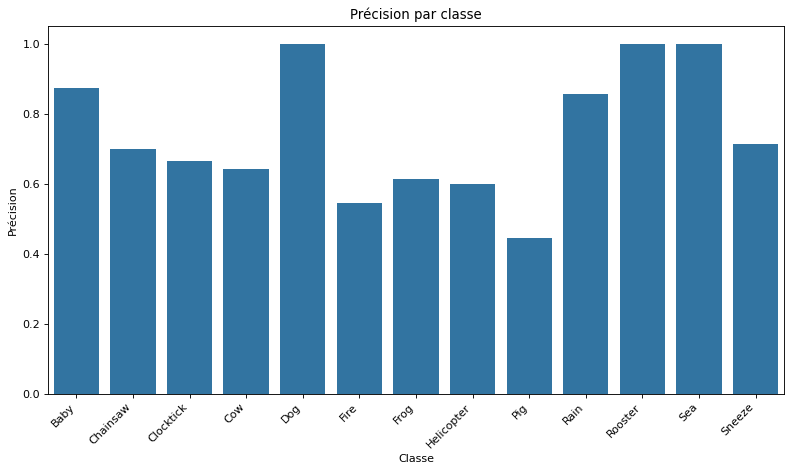

In [59]:
# Afficher la précision par classe
y_pred = model_GaussNB.predict(X_test)

class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Extraire les précisions par classe
precisions = [class_report[label]['precision'] for label in label_encoder.classes_]

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
sns.barplot(x=label_encoder.classes_, y=precisions)
plt.title('Précision par classe')
plt.xlabel('Classe')
plt.ylabel('Précision')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [60]:
# Mesurer le temps de prédiction
start_time = time.time()
y_pred = model_GaussNB.predict(X_test)
pred_m4 = time.time() - start_time

# Calculer la précision
acc_m4 = accuracy_score(y_test, y_pred)

# Créer une nouvelle entrée à ajouter au DataFrame log
model_name = "Gaussien_NB"
accuracy = acc_m4 * 100
training_time = train_m4
prediction_time = pred_m4

log_data = {"Model": [model_name], "Accuracy": [accuracy], "Training Time": [training_time], "Prediction Time": [prediction_time]}

# Créer le DataFrame à partir de log_data
log_cols = ["Model", "Accuracy", "Training Time", "Prediction Time"]
log_entry = pd.DataFrame(log_data, columns=log_cols)

# Ajouter l'entrée au DataFrame log
log = pd.concat([log, log_entry], ignore_index=True)



## Save model


In [61]:
# Sauvegarder le modèle dans un fichier avec joblib
model_filename = "Audio_Classifier_GaussianNB.joblib"
joblib.dump(model_GaussNB, model_filename)

['Audio_Classifier_GaussianNB.joblib']

## Testing the Model on Sample audio


In [62]:
# Select the file
file_name = "data/Baby/1-187207-A.wav"
# Predict the Class
ML_prediction(file_name, 'Audio_Classifier_GaussianNB.joblib',feature_types)
# play the file
ipd.Audio(file_name)

Predicted class:  Baby


# **Model 5 - KNN**


## Fitting the model


In [63]:
from sklearn.neighbors import KNeighborsClassifier

# Créer le classificateur k-NN
knn_model = KNeighborsClassifier(n_neighbors=5)


start_time = time.time()

# Entraîner le modèle
knn_model.fit(X_train, y_train)

train_m5 = time.time() - start_time

## Results


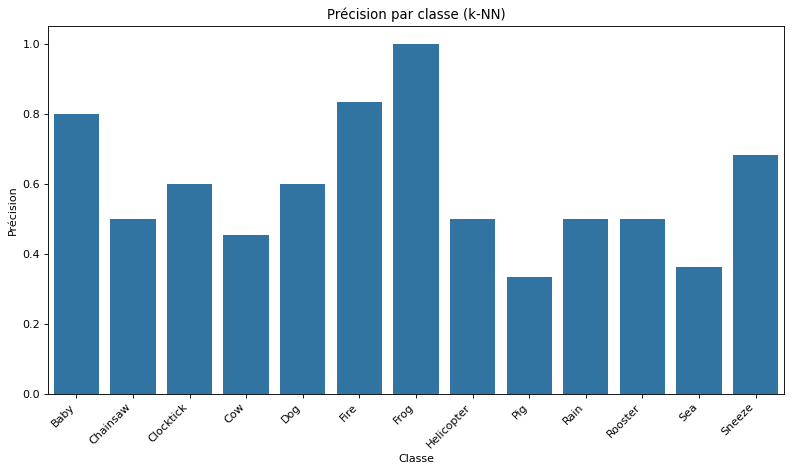

In [64]:

# Convert X_test to NumPy array if it's not
X_test = np.array(X_test)
# Faire des prédictions sur l'ensemble de test
y_pred = knn_model.predict(X_test)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)


# Afficher la précision par classe
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Extraire les précisions par classe
precisions = [class_report[label]['precision'] for label in label_encoder.classes_]

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
sns.barplot(x=label_encoder.classes_, y=precisions)
plt.title('Précision par classe (k-NN)')
plt.xlabel('Classe')
plt.ylabel('Précision')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [65]:
# Mesurer le temps de prédiction
start_time = time.time()
y_pred = knn_model.predict(X_test)
pred_m5 = time.time() - start_time

# Calculer la précision
acc_m5 = accuracy_score(y_test, y_pred)

# Créer une nouvelle entrée à ajouter au DataFrame log
model_name = "KNN"
accuracy = acc_m5 * 100
training_time = train_m5
prediction_time = pred_m5

log_data = {"Model": [model_name], "Accuracy": [accuracy], "Training Time": [training_time], "Prediction Time": [prediction_time]}

# Créer le DataFrame à partir de log_data
log_cols = ["Model", "Accuracy", "Training Time", "Prediction Time"]
log_entry = pd.DataFrame(log_data, columns=log_cols)

# Ajouter l'entrée au DataFrame log
log = pd.concat([log, log_entry], ignore_index=True)

## Save model


In [66]:
# Sauvegarder le modèle dans un fichier avec joblib
model_filename = "Audio_Classifier_KNN.joblib"
joblib.dump(knn_model, model_filename)

['Audio_Classifier_KNN.joblib']

## Testing the Model on Sample audio


In [67]:
# Select the file
file_name = "data/Baby/1-187207-A.wav"
# Predict the Class
ML_prediction(file_name, 'Audio_Classifier_KNN.joblib',feature_types)
# play the file
ipd.Audio(file_name)

Predicted class:  Cow


# **Model 6 - SVM**


## Fitting the model


In [68]:
from sklearn.svm import SVC

# Créer le classificateur SVM
svm_model = SVC(kernel='linear')


start_time = time.time()

# Entraîner le modèle
svm_model.fit(X_train, y_train)

train_m6 = time.time() - start_time

## Results


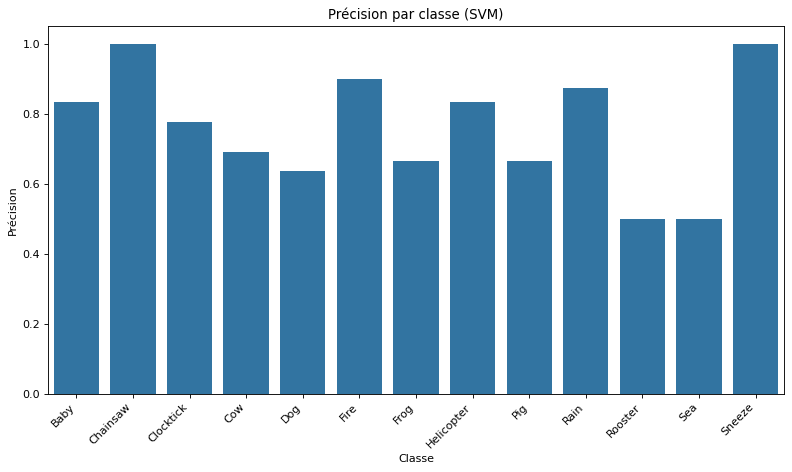

In [69]:
# Faire des prédictions sur l'ensemble de test
y_pred = svm_model.predict(X_test)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)


# Afficher la précision par classe
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Extraire les précisions par classe
precisions = [class_report[label]['precision'] for label in label_encoder.classes_]

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
sns.barplot(x=label_encoder.classes_, y=precisions)
plt.title('Précision par classe (SVM)')
plt.xlabel('Classe')
plt.ylabel('Précision')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [70]:
# Mesurer le temps de prédiction
start_time = time.time()
y_pred = knn_model.predict(X_test)
pred_m6 = time.time() - start_time

# Calculer la précision
acc_m6 = accuracy_score(y_test, y_pred)

# Créer une nouvelle entrée à ajouter au DataFrame log
model_name = "SVM"
accuracy = acc_m6 * 100
training_time = train_m6
prediction_time = pred_m6

log_data = {"Model": [model_name], "Accuracy": [accuracy], "Training Time": [training_time], "Prediction Time": [prediction_time]}

# Créer le DataFrame à partir de log_data
log_cols = ["Model", "Accuracy", "Training Time", "Prediction Time"]
log_entry = pd.DataFrame(log_data, columns=log_cols)

# Ajouter l'entrée au DataFrame log
log = pd.concat([log, log_entry], ignore_index=True)

## Save model


In [71]:
# Sauvegarder le modèle dans un fichier avec joblib
model_filename = "Audio_Classifier_SVM.joblib"
joblib.dump(svm_model, model_filename)

['Audio_Classifier_SVM.joblib']

## Testing the Model on Sample audio


In [72]:

# Select the file
file_name = "data/Baby/1-187207-A.wav"
# Predict the Class
ML_prediction(file_name, 'Audio_Classifier_SVM.joblib',feature_types)
# play the file
ipd.Audio(file_name)

Predicted class:  Dog


# **Comparative Analysis**


In [73]:
plt.rcParams["figure.figsize"] = (17, 2)
plt.rcParams["figure.dpi"] = 550


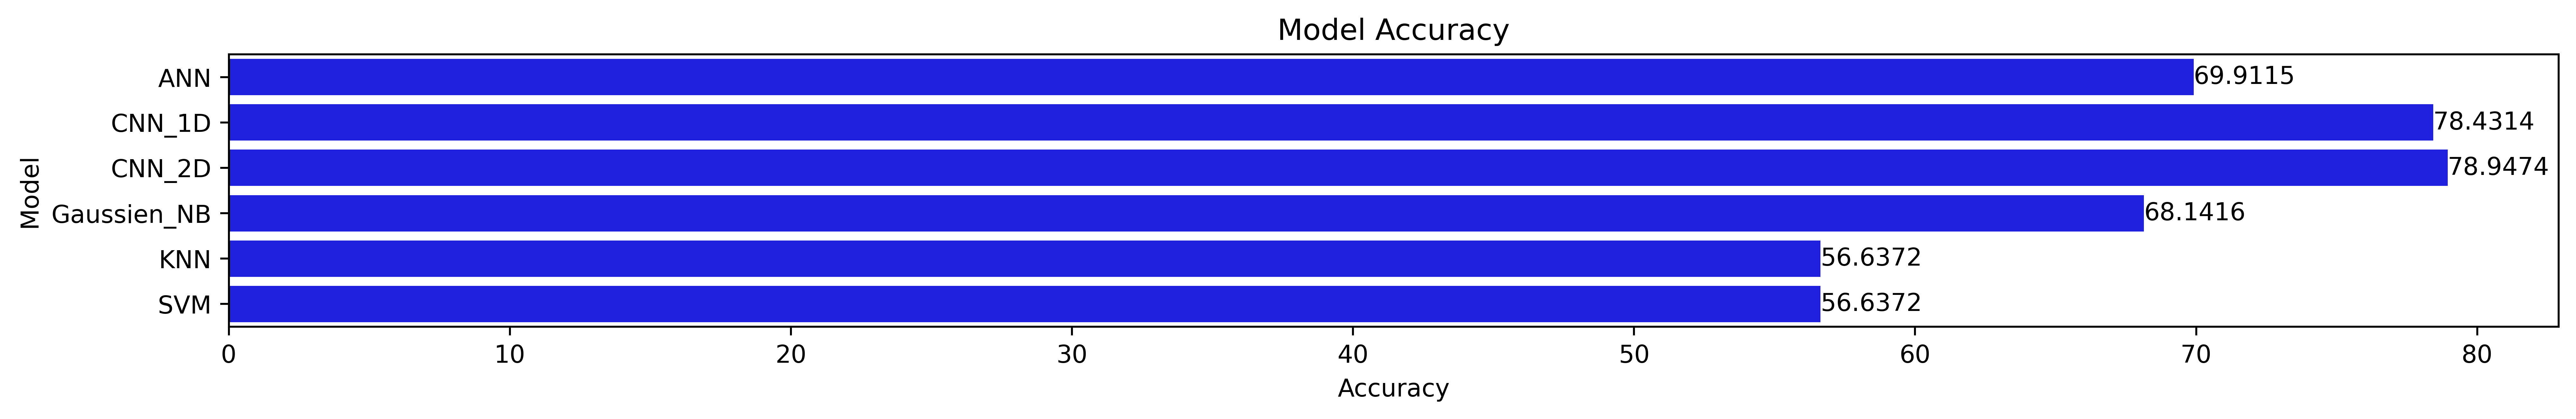

In [74]:
ax = sns.barplot(x="Accuracy", y="Model", data=log, color="b")
ax.bar_label(ax.containers[0])
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Accuracy")
plt.show()


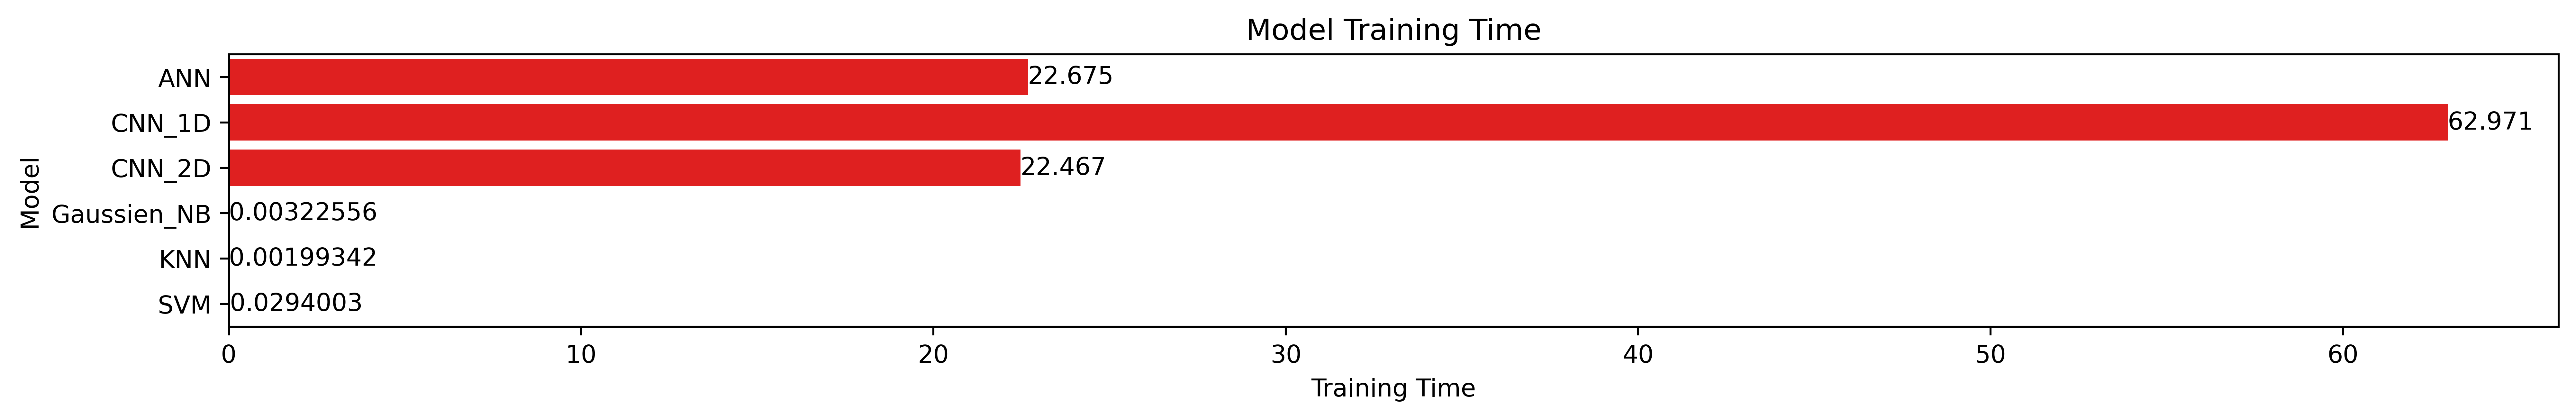

In [75]:
ax = sns.barplot(x="Training Time", y="Model", data=log, color="r")
ax.bar_label(ax.containers[0])
plt.xlabel("Training Time")
plt.ylabel("Model")
plt.title("Model Training Time")
plt.show()


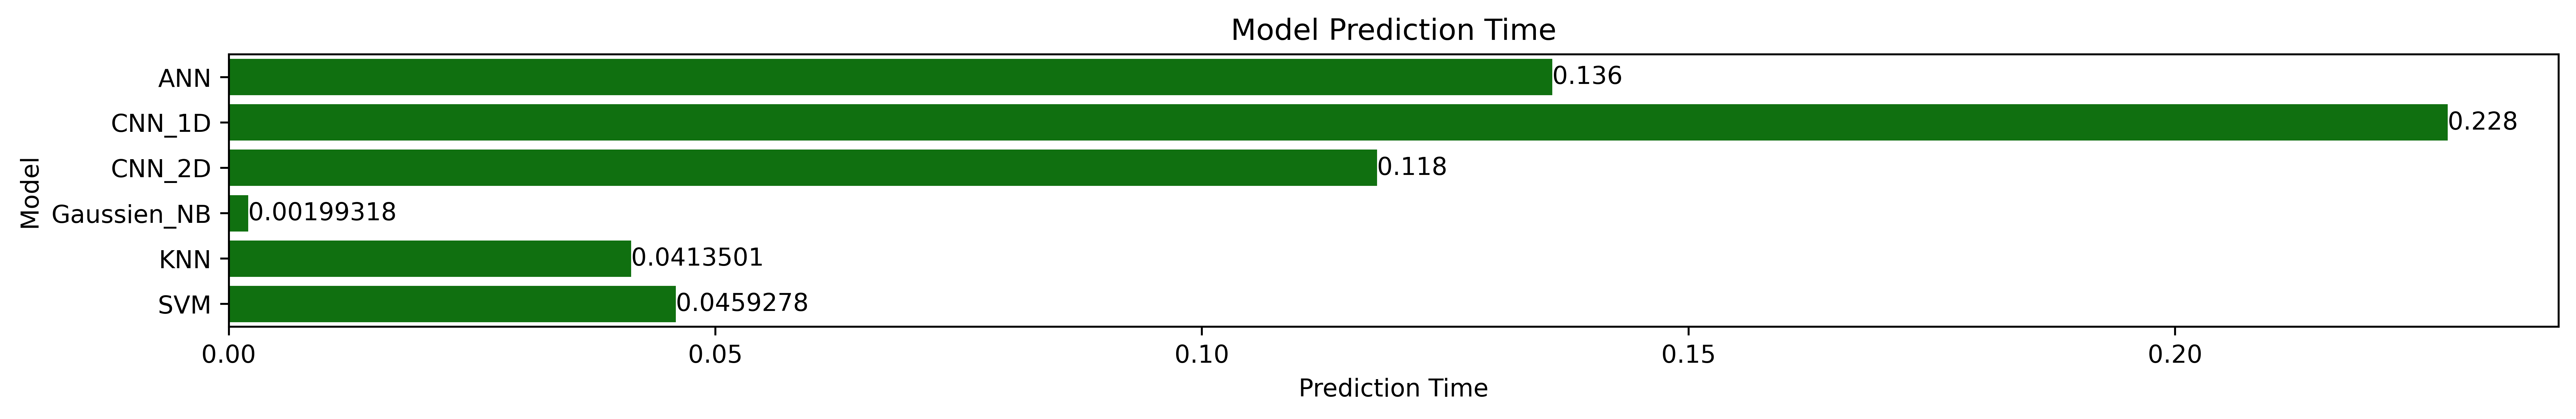

In [76]:
ax = sns.barplot(x="Prediction Time", y="Model", data=log, color="g")
ax.bar_label(ax.containers[0])
plt.xlabel("Prediction Time")
plt.ylabel("Model")
plt.title("Model Prediction Time")
plt.show()
